In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.canny import Canny

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
canny_filter = Canny(low_threshold=0, high_threshold=0.2).to(device)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        *_, edge_y_pr = canny_filter(y_pr)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.layer2 = nn.Identity()
        encoder.layer3 = nn.Identity()
        encoder.layer4 = nn.Identity()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=256, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [21]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [22]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [23]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [24]:
len(trainset), len(testset)

(1344, 191)

In [25]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7fa12667c6d0>,)

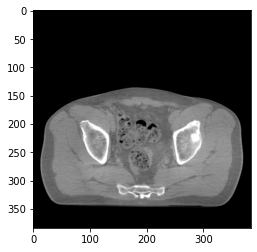

In [26]:
plt.imshow(x.squeeze(), 'gray'),

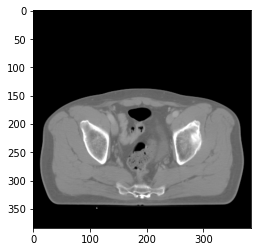

In [27]:
plt.imshow(y.squeeze(), 'gray')

In [28]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [29]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)


In [30]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [31]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [32]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [33]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [34]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [35]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [36]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [01:39,  1.68it/s]
168it [01:27,  1.92it/s]
24it [00:10,  2.36it/s]
168it [01:37,  1.73it/s]
168it [01:24,  1.98it/s]
24it [00:09,  2.48it/s]
168it [01:37,  1.73it/s]
168it [01:23,  2.01it/s]
24it [00:09,  2.41it/s]
168it [01:37,  1.73it/s]
168it [01:25,  1.97it/s]
24it [00:09,  2.45it/s]
168it [01:36,  1.74it/s]
168it [01:25,  1.96it/s]
24it [00:11,  2.02it/s]
168it [01:36,  1.74it/s]
168it [01:27,  1.93it/s]
24it [00:11,  2.09it/s]
168it [01:36,  1.74it/s]
168it [01:29,  1.87it/s]
24it [00:10,  2.30it/s]
168it [01:37,  1.73it/s]
168it [01:27,  1.91it/s]
24it [00:11,  2.13it/s]
168it [01:36,  1.73it/s]
168it [01:27,  1.91it/s]
24it [00:11,  2.15it/s]
168it [01:36,  1.74it/s]
168it [01:22,  2.03it/s]
24it [00:10,  2.20it/s]
168it [01:36,  1.75it/s]
168it [01:26,  1.95it/s]
24it [00:11,  2.09it/s]
168it [01:36,  1.75it/s]
168it [01:28,  1.89it/s]
24it [00:10,  2.28it/s]
168it [01:36,  1.74it/s]
168it [01:26,  1.94it/s]
24it [00:10,  2.24it/s]
168it [01:36,  1.73it/s]
168it [01:25,

In [37]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [38]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [39]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9023271203041077
psnr score = 26.16073989868164
snr score = 16.22368049621582
mae error = 0.016689645126461983
air dice score = 0.9970539259638814
bone dice score = 0.9213788932579169
contour dice score = 0.3313397169113159


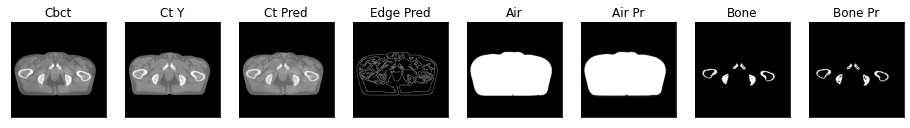

ssim score = 0.9035067558288574
psnr score = 26.031085968017578
snr score = 16.141559600830078
mae error = 0.017153257504105568
air dice score = 0.9971149206849383
bone dice score = 0.9203007518808978
contour dice score = 0.36189335584640503


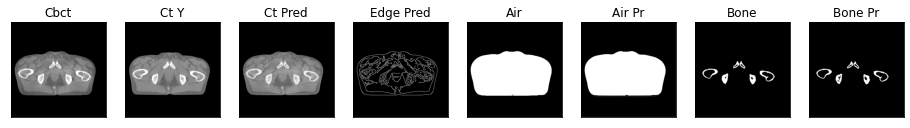

ssim score = 0.9014703631401062
psnr score = 25.701171875
snr score = 15.974540710449219
mae error = 0.01893657259643078
air dice score = 0.9970848352341024
bone dice score = 0.9029188633161512
contour dice score = 0.3666866421699524


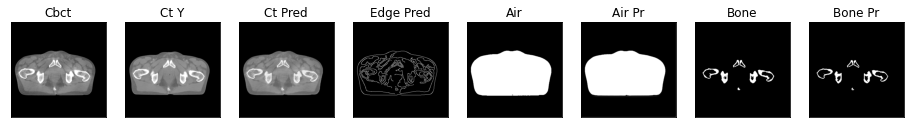

ssim score = 0.8993549942970276
psnr score = 25.572731018066406
snr score = 15.935355186462402
mae error = 0.019841963425278664
air dice score = 0.9976320151551054
bone dice score = 0.8881826742009393
contour dice score = 0.44618159532546997


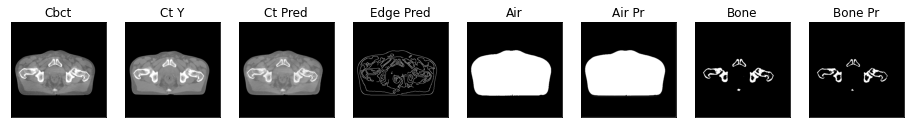

ssim score = 0.8980698585510254
psnr score = 25.571996688842773
snr score = 15.974921226501465
mae error = 0.020117435604333878
air dice score = 0.9979311641903349
bone dice score = 0.8483381025770598
contour dice score = 0.4837545156478882


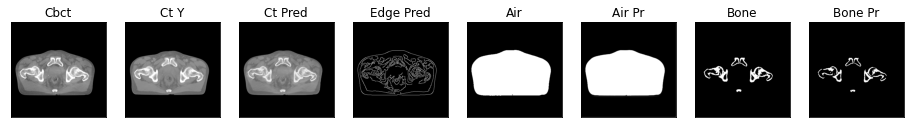

ssim score = 0.8939207792282104
psnr score = 25.14065170288086
snr score = 15.6801118850708
mae error = 0.022185707464814186
air dice score = 0.998201456720691
bone dice score = 0.8093535607323475
contour dice score = 0.5072463750839233


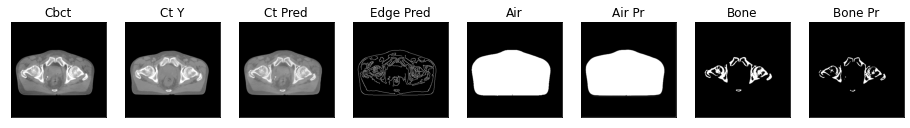

ssim score = 0.8920820951461792
psnr score = 24.86628532409668
snr score = 15.381689071655273
mae error = 0.02231530286371708
air dice score = 0.9982093016276365
bone dice score = 0.7934598759651056
contour dice score = 0.4600484371185303


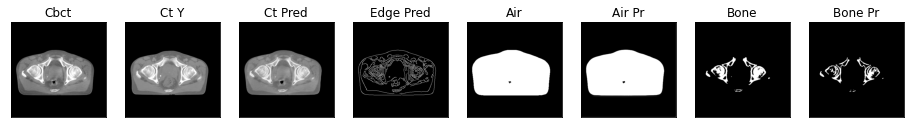

ssim score = 0.8931507468223572
psnr score = 25.572309494018555
snr score = 15.902174949645996
mae error = 0.020226720720529556
air dice score = 0.9976449749401203
bone dice score = 0.837190662259922
contour dice score = 0.4131227135658264


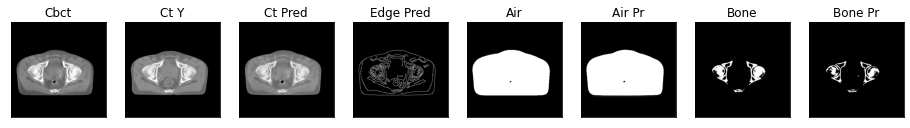

1it [00:02,  2.96s/it]

ssim score = 0.8954171538352966
psnr score = 26.102210998535156
snr score = 16.337520599365234
mae error = 0.019007226452231407
air dice score = 0.9980055682105816
bone dice score = 0.8776069096284221
contour dice score = 0.327848881483078


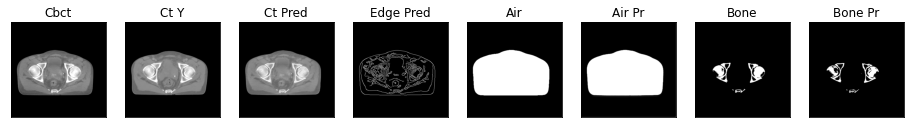

ssim score = 0.8979666233062744
psnr score = 25.975326538085938
snr score = 16.195356369018555
mae error = 0.019185390323400497
air dice score = 0.9970532154619548
bone dice score = 0.8843165152688593
contour dice score = 0.27889907360076904


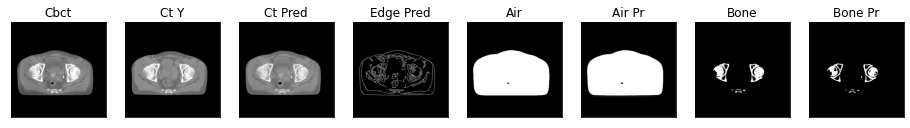

ssim score = 0.9025911688804626
psnr score = 26.212751388549805
snr score = 16.465049743652344
mae error = 0.01910662092268467
air dice score = 0.9971591200451289
bone dice score = 0.9112021857933605
contour dice score = 0.27679118514060974


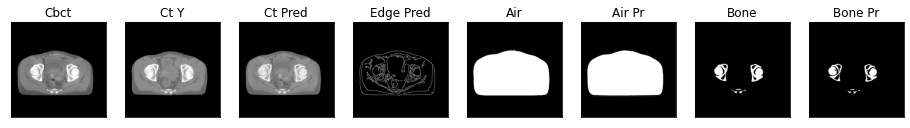

ssim score = 0.8991098403930664
psnr score = 25.121288299560547
snr score = 15.397295951843262
mae error = 0.020737729966640472
air dice score = 0.9969300338111173
bone dice score = 0.8949074074086236
contour dice score = 0.27958306670188904


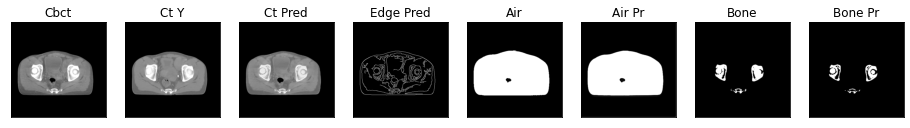

ssim score = 0.9026131629943848
psnr score = 24.4815616607666
snr score = 14.72564697265625
mae error = 0.021464180201292038
air dice score = 0.9965913262363033
bone dice score = 0.9300312575146665
contour dice score = 0.2701043486595154


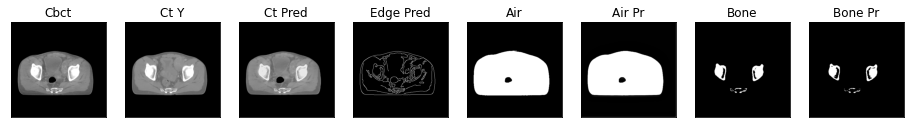

ssim score = 0.8998705148696899
psnr score = 24.537641525268555
snr score = 14.639769554138184
mae error = 0.02008167654275894
air dice score = 0.9962233012790036
bone dice score = 0.8950026581619484
contour dice score = 0.28960394859313965


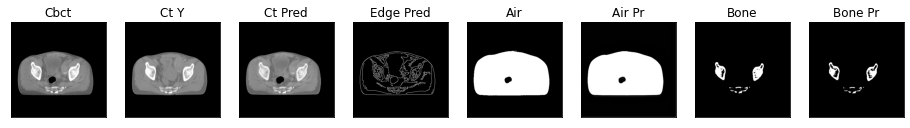

ssim score = 0.8952775001525879
psnr score = 24.424245834350586
snr score = 14.440709114074707
mae error = 0.020074116066098213
air dice score = 0.9964795847824506
bone dice score = 0.8986155782422233
contour dice score = 0.271940678358078


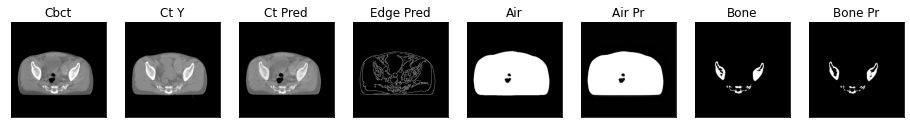

ssim score = 0.8865793347358704
psnr score = 24.140438079833984
snr score = 14.180389404296875
mae error = 0.02139987237751484
air dice score = 0.9970801202177642
bone dice score = 0.8993018259949074
contour dice score = 0.27460816502571106


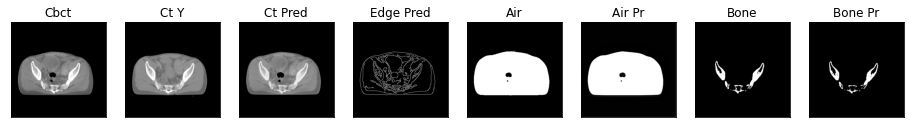

2it [00:05,  2.79s/it]

ssim score = 0.8839477896690369
psnr score = 23.340932846069336
snr score = 13.378339767456055
mae error = 0.023169297724962234
air dice score = 0.9968398268398303
bone dice score = 0.8829362524161889
contour dice score = 0.26339003443717957


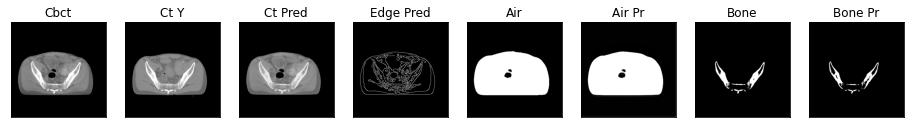

ssim score = 0.8739067316055298
psnr score = 22.730205535888672
snr score = 12.665852546691895
mae error = 0.02429783344268799
air dice score = 0.9958433603150341
bone dice score = 0.8601324503329784
contour dice score = 0.25341615080833435


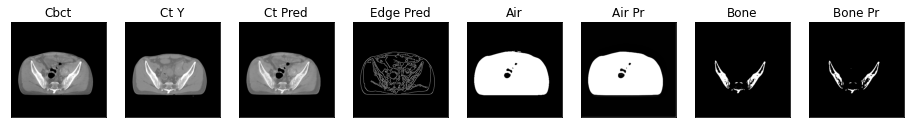

ssim score = 0.8715149760246277
psnr score = 22.39484405517578
snr score = 12.279808044433594
mae error = 0.025035789236426353
air dice score = 0.9948737170512354
bone dice score = 0.8495575221258809
contour dice score = 0.26325878500938416


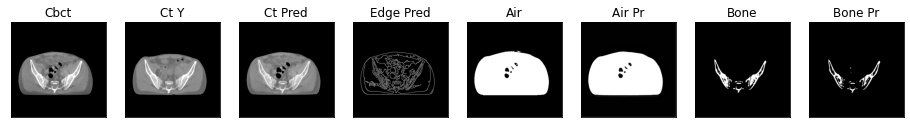

ssim score = 0.8760210871696472
psnr score = 22.55136489868164
snr score = 12.424020767211914
mae error = 0.024845033884048462
air dice score = 0.9953970208187808
bone dice score = 0.8625489931090343
contour dice score = 0.2323809564113617


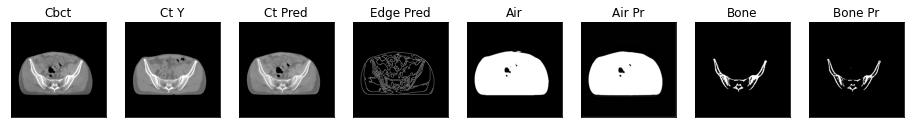

ssim score = 0.8741580247879028
psnr score = 22.598041534423828
snr score = 12.405852317810059
mae error = 0.024412214756011963
air dice score = 0.9952089909776847
bone dice score = 0.866618181820122
contour dice score = 0.2402055263519287


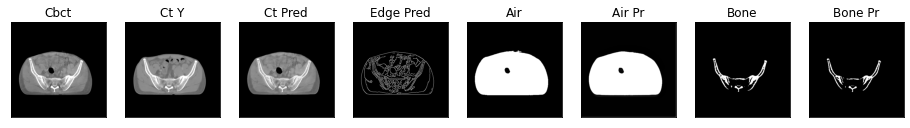

ssim score = 0.8729920387268066
psnr score = 22.512033462524414
snr score = 12.260412216186523
mae error = 0.024355411529541016
air dice score = 0.9938321023848522
bone dice score = 0.8740550563418334
contour dice score = 0.2613195478916168


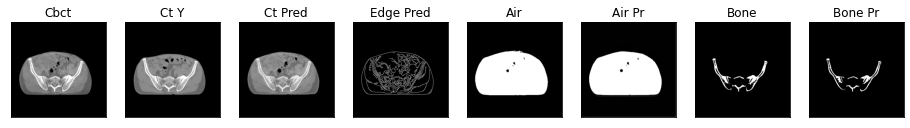

ssim score = 0.8798540830612183
psnr score = 22.87570571899414
snr score = 12.590655326843262
mae error = 0.023368876427412033
air dice score = 0.9950922899989808
bone dice score = 0.8671556642234833
contour dice score = 0.3240078091621399


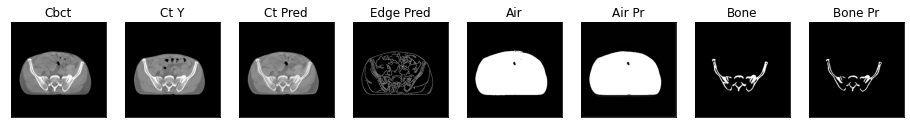

ssim score = 0.8785793781280518
psnr score = 22.946849822998047
snr score = 12.613237380981445
mae error = 0.023281142115592957
air dice score = 0.9949184888827632
bone dice score = 0.8574824990112603
contour dice score = 0.2641008496284485


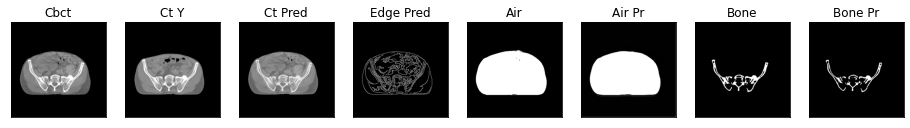

3it [00:08,  2.81s/it]

ssim score = 0.8744440078735352
psnr score = 22.762237548828125
snr score = 12.331623077392578
mae error = 0.023474160581827164
air dice score = 0.9942842478536834
bone dice score = 0.8471973381130382
contour dice score = 0.2634408473968506


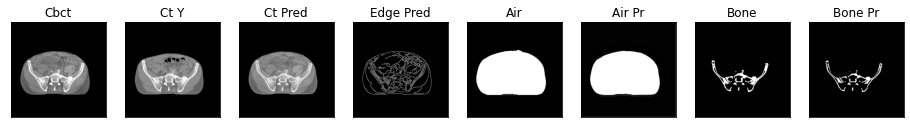

ssim score = 0.8760691285133362
psnr score = 22.86458969116211
snr score = 12.351241111755371
mae error = 0.023089725524187088
air dice score = 0.9948620134708293
bone dice score = 0.8409785932741976
contour dice score = 0.3394683003425598


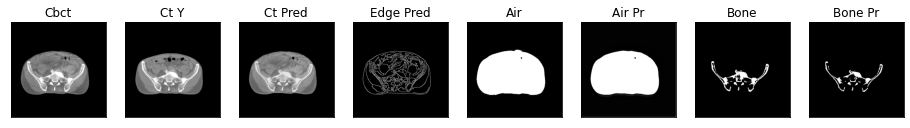

ssim score = 0.8714606165885925
psnr score = 22.90106201171875
snr score = 12.296528816223145
mae error = 0.02339927665889263
air dice score = 0.9953156748470047
bone dice score = 0.835029526324475
contour dice score = 0.45562544465065


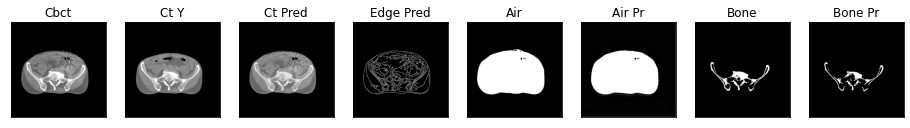

ssim score = 0.8721199035644531
psnr score = 22.84183120727539
snr score = 12.196188926696777
mae error = 0.023138955235481262
air dice score = 0.994248759657401
bone dice score = 0.848800094575614
contour dice score = 0.5049505233764648


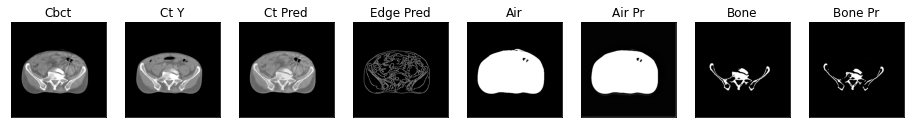

ssim score = 0.8624395132064819
psnr score = 23.893775939941406
snr score = 15.2659330368042
mae error = 0.022390220314264297
air dice score = 0.997398745713493
bone dice score = 0.9486627728266627
contour dice score = 0.5483871102333069


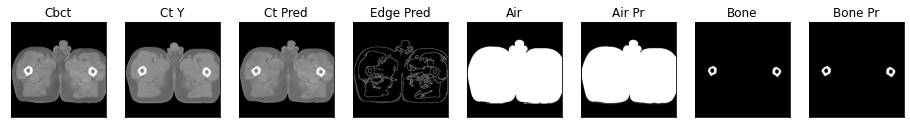

ssim score = 0.8701460361480713
psnr score = 24.56669044494629
snr score = 15.978105545043945
mae error = 0.021053174510598183
air dice score = 0.9966949028056623
bone dice score = 0.9508863702426362
contour dice score = 0.49283909797668457


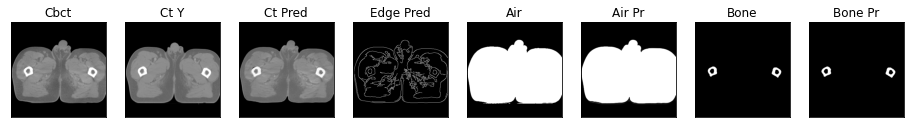

ssim score = 0.8782190084457397
psnr score = 25.191926956176758
snr score = 16.6907901763916
mae error = 0.020924188196659088
air dice score = 0.9970521914069878
bone dice score = 0.9437528815135142
contour dice score = 0.45737123489379883


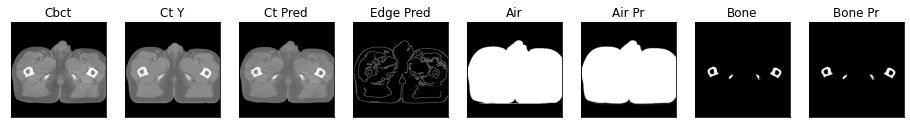

ssim score = 0.8878376483917236
psnr score = 25.487031936645508
snr score = 17.148454666137695
mae error = 0.022945603355765343
air dice score = 0.9982782057091084
bone dice score = 0.9398836457669703
contour dice score = 0.47860100865364075


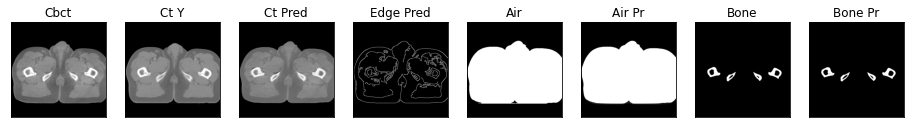

4it [00:10,  2.70s/it]

ssim score = 0.8879229426383972
psnr score = 25.552696228027344
snr score = 17.342260360717773
mae error = 0.024324091151356697
air dice score = 0.9985025168542038
bone dice score = 0.9187730758318834
contour dice score = 0.43607625365257263


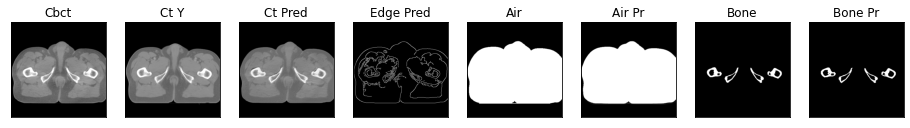

ssim score = 0.8876680135726929
psnr score = 25.68173599243164
snr score = 17.574539184570312
mae error = 0.025483498349785805
air dice score = 0.9985860474033608
bone dice score = 0.9011435832287021
contour dice score = 0.45065176486968994


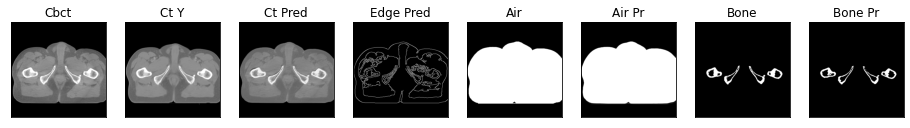

ssim score = 0.887598991394043
psnr score = 25.773731231689453
snr score = 17.733633041381836
mae error = 0.026457488536834717
air dice score = 0.9987107710305483
bone dice score = 0.893081761007558
contour dice score = 0.41581395268440247


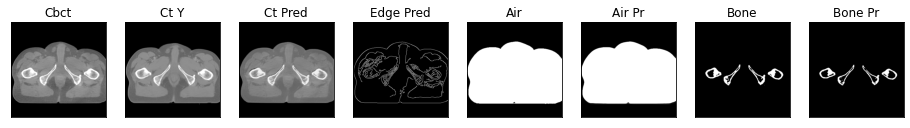

ssim score = 0.8877057433128357
psnr score = 25.94522476196289
snr score = 17.89523696899414
mae error = 0.025839392095804214
air dice score = 0.9987024118473378
bone dice score = 0.9009591791222288
contour dice score = 0.42168673872947693


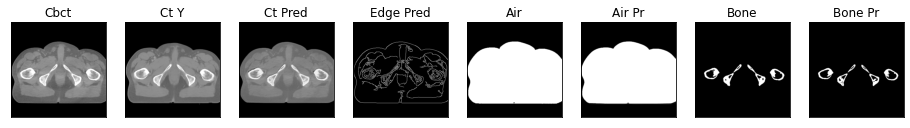

ssim score = 0.8909317851066589
psnr score = 26.216205596923828
snr score = 18.15255355834961
mae error = 0.02524631842970848
air dice score = 0.9988241163055879
bone dice score = 0.8987719880528955
contour dice score = 0.41353732347488403


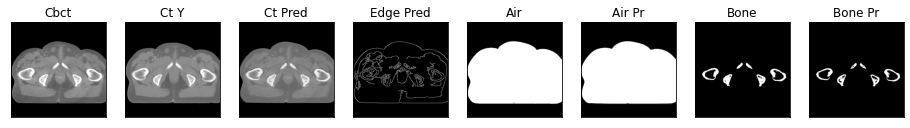

ssim score = 0.8940944075584412
psnr score = 26.382095336914062
snr score = 18.3304443359375
mae error = 0.025237301364541054
air dice score = 0.9989562081890219
bone dice score = 0.8929699380056968
contour dice score = 0.42691415548324585


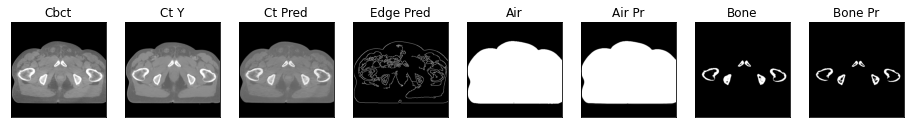

ssim score = 0.8948866128921509
psnr score = 26.28289794921875
snr score = 18.270334243774414
mae error = 0.025811491534113884
air dice score = 0.9990039840637456
bone dice score = 0.898446833931918
contour dice score = 0.44134077429771423


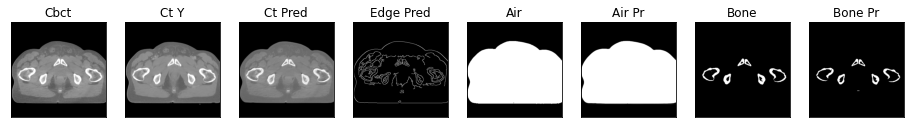

ssim score = 0.8916963338851929
psnr score = 25.631553649902344
snr score = 17.760278701782227
mae error = 0.028624707832932472
air dice score = 0.999027537297503
bone dice score = 0.8850682504961439
contour dice score = 0.41736695170402527


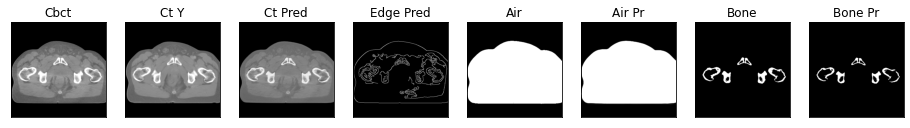

5it [00:13,  2.63s/it]

ssim score = 0.8896560072898865
psnr score = 25.280967712402344
snr score = 17.504379272460938
mae error = 0.03084908239543438
air dice score = 0.9990858146934517
bone dice score = 0.8549973180774629
contour dice score = 0.3878220021724701


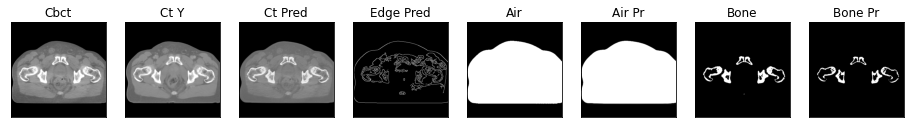

ssim score = 0.8761394023895264
psnr score = 24.62637710571289
snr score = 16.81574058532715
mae error = 0.03178181126713753
air dice score = 0.9988447429850895
bone dice score = 0.808697996227795
contour dice score = 0.4478873312473297


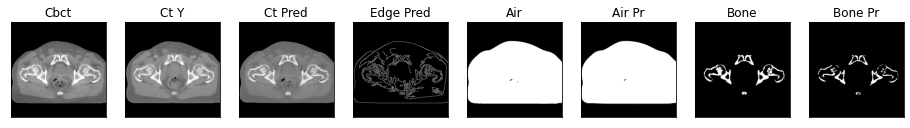

ssim score = 0.8735312223434448
psnr score = 23.688371658325195
snr score = 15.94992446899414
mae error = 0.03390849381685257
air dice score = 0.998395228799656
bone dice score = 0.7549764169817333
contour dice score = 0.4320000112056732


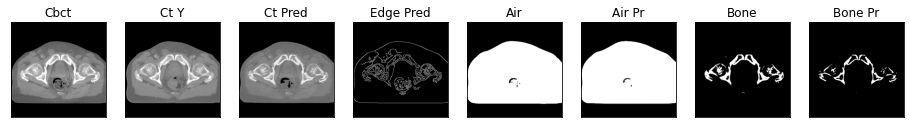

ssim score = 0.8742152452468872
psnr score = 24.197214126586914
snr score = 16.322668075561523
mae error = 0.03161868453025818
air dice score = 0.9984198794782607
bone dice score = 0.8009905894026647
contour dice score = 0.4537735879421234


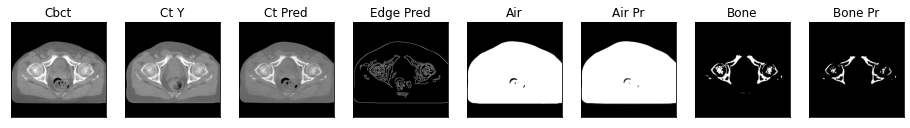

ssim score = 0.8815957307815552
psnr score = 24.821088790893555
snr score = 16.767980575561523
mae error = 0.028363283723592758
air dice score = 0.9985596769819516
bone dice score = 0.8246774368445767
contour dice score = 0.4976348280906677


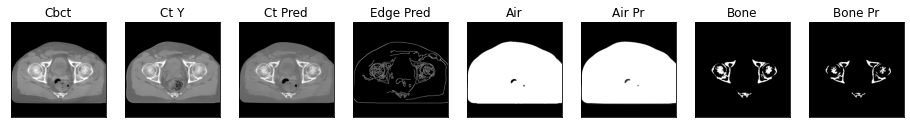

ssim score = 0.8781617879867554
psnr score = 25.188608169555664
snr score = 17.04491424560547
mae error = 0.027211418375372887
air dice score = 0.9987806350356159
bone dice score = 0.8497199380306313
contour dice score = 0.5266159772872925


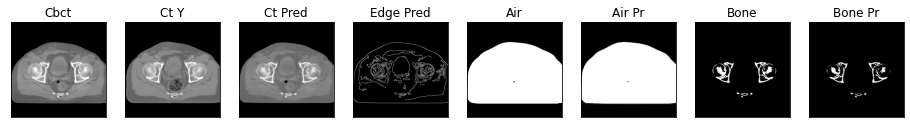

ssim score = 0.8783456087112427
psnr score = 25.102840423583984
snr score = 16.974834442138672
mae error = 0.027428608387708664
air dice score = 0.9988418276081625
bone dice score = 0.850083845725544
contour dice score = 0.5347950458526611


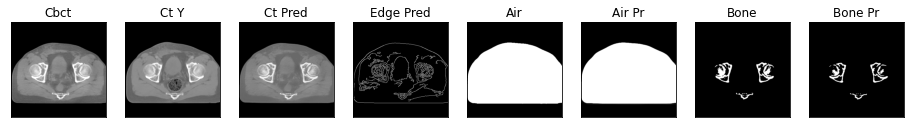

ssim score = 0.8662396669387817
psnr score = 24.668235778808594
snr score = 16.55026626586914
mae error = 0.028698397800326347
air dice score = 0.9988479613792774
bone dice score = 0.8310831701553015
contour dice score = 0.5393794775009155


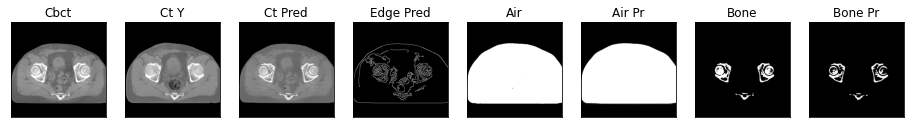

6it [00:16,  2.77s/it]

ssim score = 0.8762008547782898
psnr score = 24.83485221862793
snr score = 16.778470993041992
mae error = 0.028800159692764282
air dice score = 0.9987338287916331
bone dice score = 0.8567170111301996
contour dice score = 0.5288782715797424


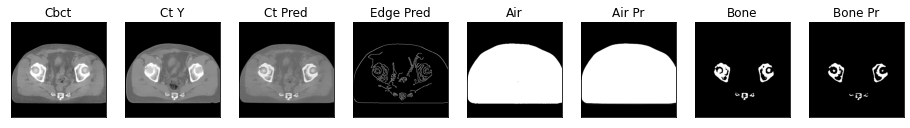

ssim score = 0.8770569562911987
psnr score = 24.91267204284668
snr score = 16.926376342773438
mae error = 0.029703279957175255
air dice score = 0.9985528752406774
bone dice score = 0.8985725018792395
contour dice score = 0.47260600328445435


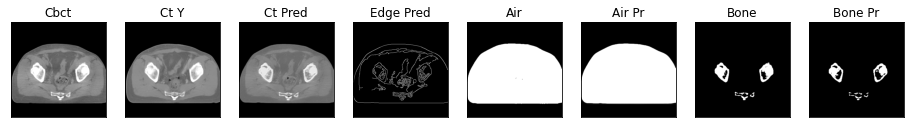

ssim score = 0.8844306468963623
psnr score = 25.211631774902344
snr score = 17.106231689453125
mae error = 0.02771521359682083
air dice score = 0.9986081731506186
bone dice score = 0.8865011475079647
contour dice score = 0.49833253026008606


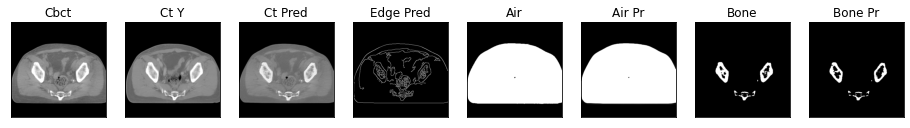

ssim score = 0.8741271495819092
psnr score = 24.309402465820312
snr score = 16.285625457763672
mae error = 0.030373424291610718
air dice score = 0.9984192726203323
bone dice score = 0.8736462093874512
contour dice score = 0.455720454454422


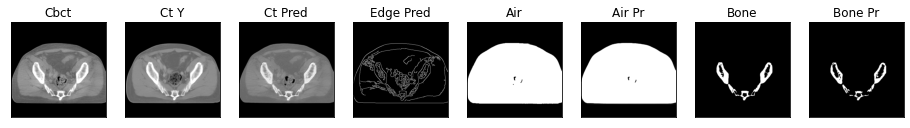

ssim score = 0.8720263838768005
psnr score = 24.121706008911133
snr score = 16.178077697753906
mae error = 0.03209440037608147
air dice score = 0.9981960606857426
bone dice score = 0.841382613555988
contour dice score = 0.3685220777988434


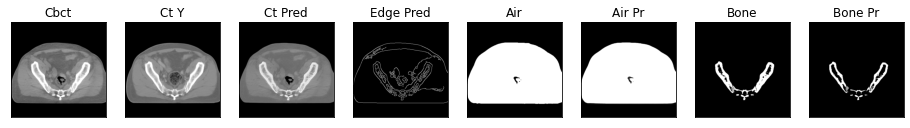

ssim score = 0.8555279970169067
psnr score = 23.71078109741211
snr score = 15.788708686828613
mae error = 0.03318559378385544
air dice score = 0.9982244946521301
bone dice score = 0.8186114732739683
contour dice score = 0.35617759823799133


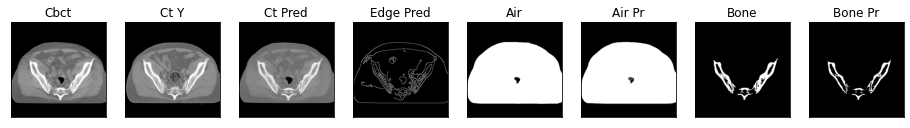

ssim score = 0.8580899834632874
psnr score = 24.309993743896484
snr score = 16.40045928955078
mae error = 0.0322280190885067
air dice score = 0.9982810797724256
bone dice score = 0.827098577654961
contour dice score = 0.3275529742240906


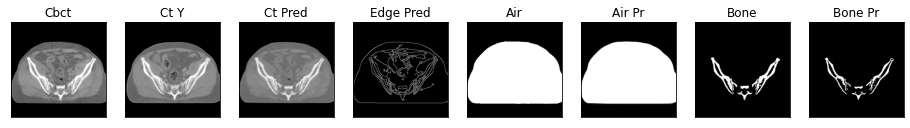

ssim score = 0.7944049835205078
psnr score = 20.819766998291016
snr score = 10.699973106384277
mae error = 0.0341307632625103
air dice score = 0.9972405047465129
bone dice score = 0.9307450157415859
contour dice score = 0.48203426599502563


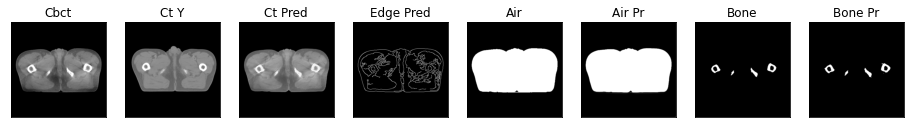

7it [00:18,  2.69s/it]

ssim score = 0.7877116203308105
psnr score = 20.578655242919922
snr score = 10.671844482421875
mae error = 0.035323936492204666
air dice score = 0.9974881285226135
bone dice score = 0.9129079193532964
contour dice score = 0.4658590257167816


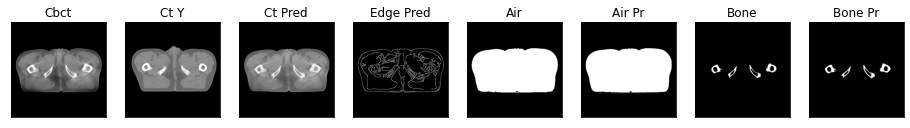

ssim score = 0.7861244678497314
psnr score = 20.586532592773438
snr score = 10.810860633850098
mae error = 0.035568464547395706
air dice score = 0.9976428628181494
bone dice score = 0.9008136381266794
contour dice score = 0.4744645655155182


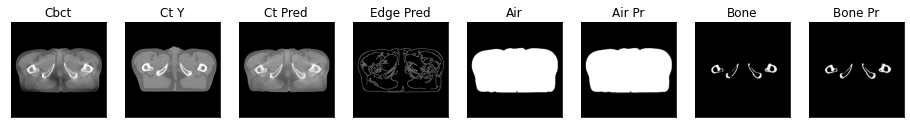

ssim score = 0.7901028394699097
psnr score = 20.883556365966797
snr score = 11.178284645080566
mae error = 0.034552786499261856
air dice score = 0.9974272744035777
bone dice score = 0.8848800446366956
contour dice score = 0.44846490025520325


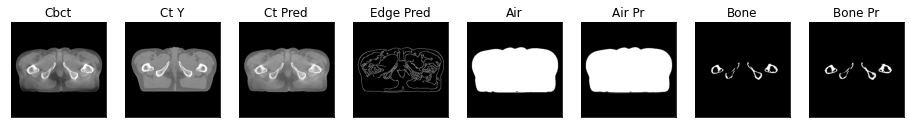

ssim score = 0.7915570735931396
psnr score = 21.023290634155273
snr score = 11.365585327148438
mae error = 0.03409668430685997
air dice score = 0.9971572769337101
bone dice score = 0.8852518639773549
contour dice score = 0.48309704661369324


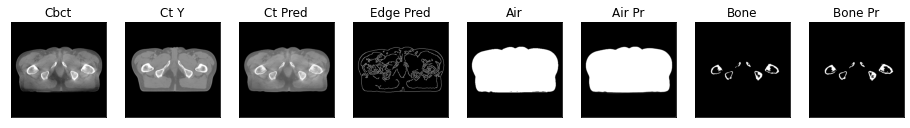

ssim score = 0.7892109155654907
psnr score = 21.140348434448242
snr score = 11.488258361816406
mae error = 0.03363886848092079
air dice score = 0.9970893753485803
bone dice score = 0.9055047516602922
contour dice score = 0.48671627044677734


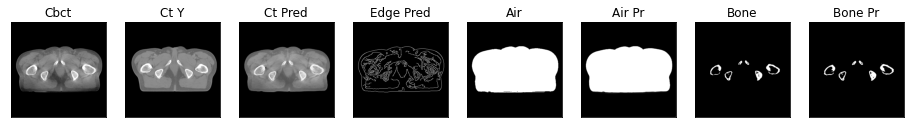

ssim score = 0.7910722494125366
psnr score = 21.184358596801758
snr score = 11.525766372680664
mae error = 0.03318822756409645
air dice score = 0.9967600997159687
bone dice score = 0.8984817998921075
contour dice score = 0.5095744729042053


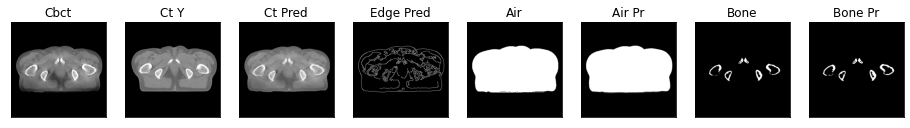

ssim score = 0.7907866835594177
psnr score = 21.073787689208984
snr score = 11.429306030273438
mae error = 0.03340314328670502
air dice score = 0.9966153926058043
bone dice score = 0.913535861946548
contour dice score = 0.45826688408851624


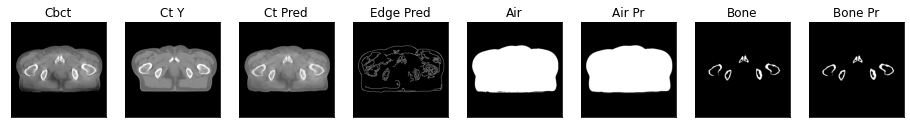

ssim score = 0.7890351414680481
psnr score = 20.995285034179688
snr score = 11.4088134765625
mae error = 0.034340277314186096
air dice score = 0.9961228234153805
bone dice score = 0.9071635078717127
contour dice score = 0.5483698844909668


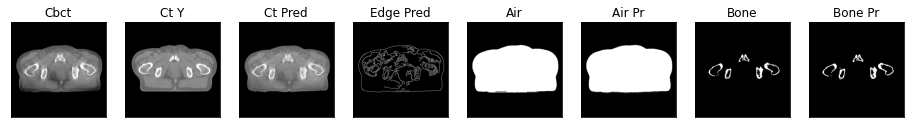

8it [00:21,  2.60s/it]

ssim score = 0.7827995419502258
psnr score = 20.815860748291016
snr score = 11.327948570251465
mae error = 0.03603572025895119
air dice score = 0.9956693524733038
bone dice score = 0.8946256038663251
contour dice score = 0.527484118938446


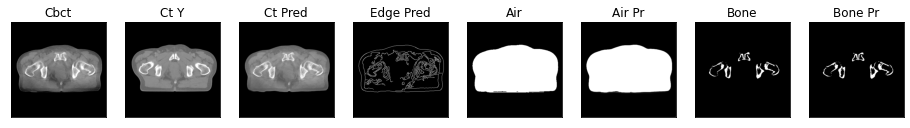

ssim score = 0.7730430364608765
psnr score = 20.672576904296875
snr score = 11.220491409301758
mae error = 0.03760456293821335
air dice score = 0.9960815384482926
bone dice score = 0.880523731589339
contour dice score = 0.47608813643455505


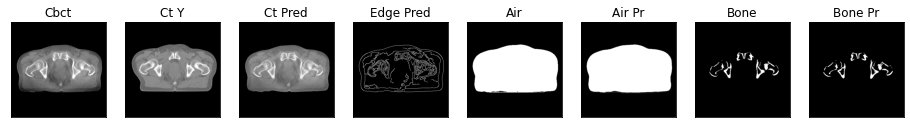

ssim score = 0.7649135589599609
psnr score = 20.57114601135254
snr score = 11.15176773071289
mae error = 0.03801444172859192
air dice score = 0.9960858531549778
bone dice score = 0.8602971241670943
contour dice score = 0.5388323664665222


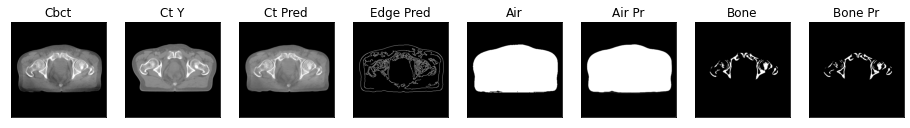

ssim score = 0.7630534172058105
psnr score = 20.60148048400879
snr score = 11.298917770385742
mae error = 0.0381493978202343
air dice score = 0.9964471590175952
bone dice score = 0.8874555745703903
contour dice score = 0.6241433620452881


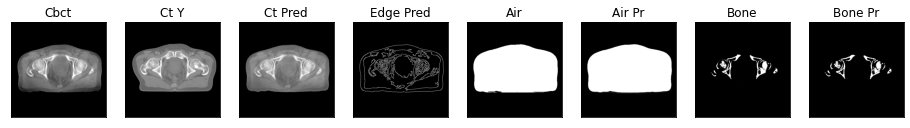

ssim score = 0.7658131122589111
psnr score = 20.60635757446289
snr score = 11.287809371948242
mae error = 0.03798197582364082
air dice score = 0.99695483870968
bone dice score = 0.886818687432052
contour dice score = 0.5759390592575073


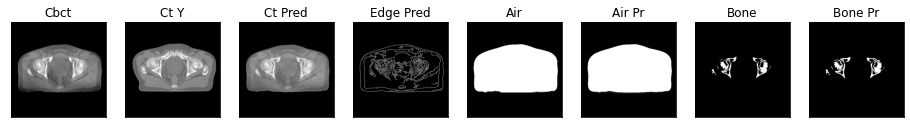

ssim score = 0.7801017165184021
psnr score = 21.14557456970215
snr score = 11.627862930297852
mae error = 0.03466124087572098
air dice score = 0.9970684571143671
bone dice score = 0.9067296340037377
contour dice score = 0.5950590968132019


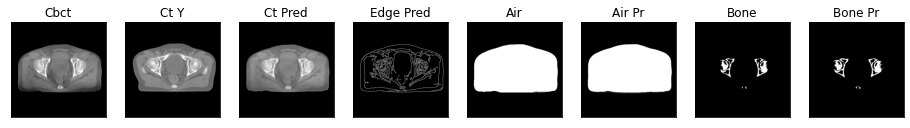

ssim score = 0.7988367676734924
psnr score = 21.89016342163086
snr score = 12.202058792114258
mae error = 0.03133939951658249
air dice score = 0.9971671874463507
bone dice score = 0.9289981936928026
contour dice score = 0.5841850638389587


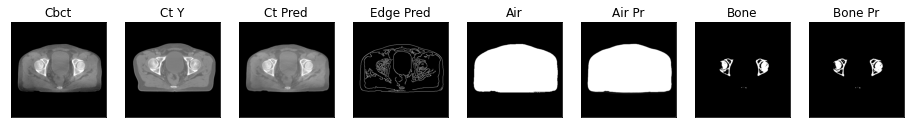

ssim score = 0.8060626983642578
psnr score = 22.30912971496582
snr score = 12.635191917419434
mae error = 0.02985461615025997
air dice score = 0.996625036405067
bone dice score = 0.9252773693366492
contour dice score = 0.5932656526565552


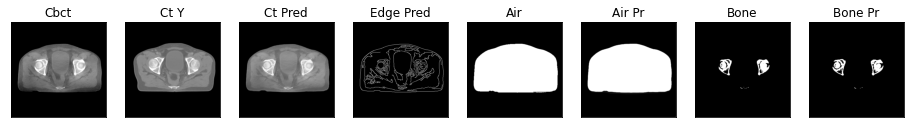

9it [00:24,  2.70s/it]

ssim score = 0.8121654987335205
psnr score = 22.533977508544922
snr score = 12.94186782836914
mae error = 0.02919589914381504
air dice score = 0.9972734809699252
bone dice score = 0.9361877315776562
contour dice score = 0.5497012734413147


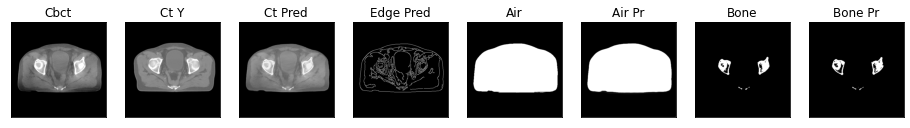

ssim score = 0.8091593384742737
psnr score = 22.422950744628906
snr score = 12.923016548156738
mae error = 0.03026052936911583
air dice score = 0.99748608826813
bone dice score = 0.9280308651145863
contour dice score = 0.549559473991394


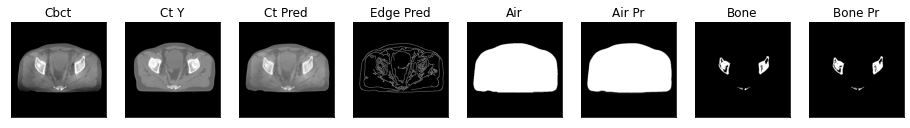

ssim score = 0.8005366325378418
psnr score = 22.660072326660156
snr score = 13.096709251403809
mae error = 0.02946646697819233
air dice score = 0.9967241496367738
bone dice score = 0.951683748170625
contour dice score = 0.5954935550689697


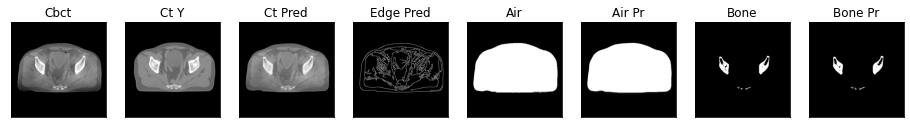

ssim score = 0.8026735186576843
psnr score = 22.70428466796875
snr score = 13.10452938079834
mae error = 0.02896999381482601
air dice score = 0.9967601309517778
bone dice score = 0.942311064353107
contour dice score = 0.5484557747840881


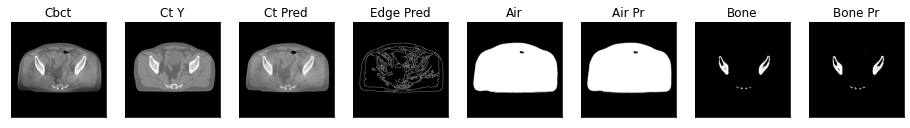

ssim score = 0.8006929755210876
psnr score = 22.3903865814209
snr score = 12.828377723693848
mae error = 0.03045462630689144
air dice score = 0.9964290864059336
bone dice score = 0.9143230869863583
contour dice score = 0.5605095624923706


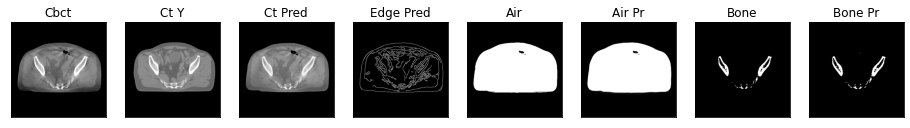

ssim score = 0.8013350367546082
psnr score = 22.360065460205078
snr score = 12.928560256958008
mae error = 0.03094536066055298
air dice score = 0.9960534021371074
bone dice score = 0.9117689951886865
contour dice score = 0.5825761556625366


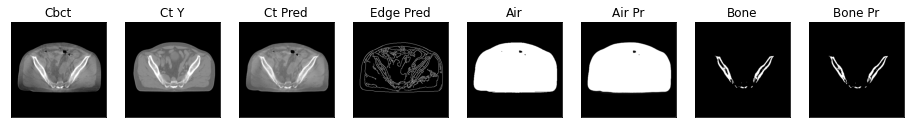

ssim score = 0.8033648729324341
psnr score = 22.19186782836914
snr score = 12.77811050415039
mae error = 0.031499557197093964
air dice score = 0.9963707616289007
bone dice score = 0.8847125710694139
contour dice score = 0.548872172832489


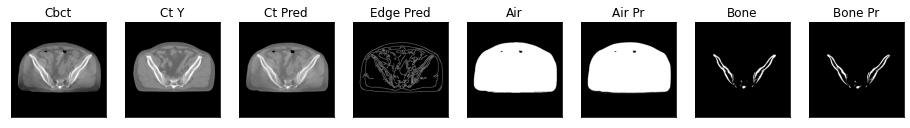

ssim score = 0.805263102054596
psnr score = 22.57282257080078
snr score = 13.147798538208008
mae error = 0.030394580215215683
air dice score = 0.9964061403658923
bone dice score = 0.888888888890768
contour dice score = 0.5348460078239441


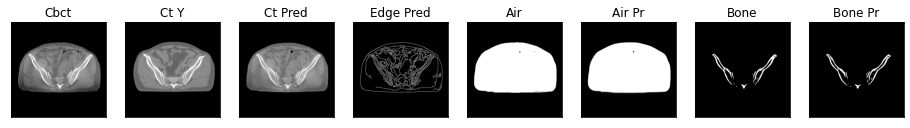

10it [00:26,  2.62s/it]

ssim score = 0.8107523918151855
psnr score = 22.711856842041016
snr score = 13.286090850830078
mae error = 0.029710199683904648
air dice score = 0.9963408349080946
bone dice score = 0.8895330112739206
contour dice score = 0.5329700112342834


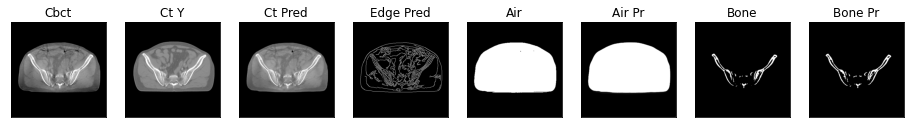

ssim score = 0.8585400581359863
psnr score = 23.550323486328125
snr score = 13.984457015991211
mae error = 0.021301668137311935
air dice score = 0.996745832836061
bone dice score = 0.9036827195501529
contour dice score = 0.46684351563453674


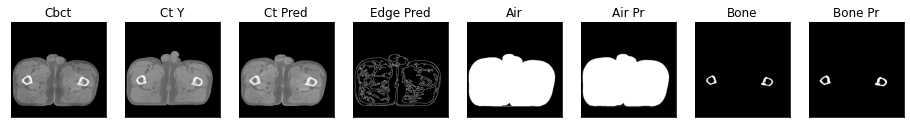

ssim score = 0.8605473041534424
psnr score = 23.860614776611328
snr score = 14.359139442443848
mae error = 0.020998800173401833
air dice score = 0.9966253862628748
bone dice score = 0.8899645046824793
contour dice score = 0.4632352888584137


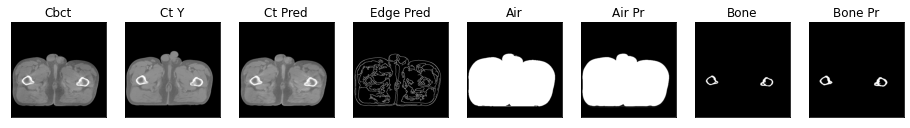

ssim score = 0.8711584806442261
psnr score = 25.250503540039062
snr score = 15.888242721557617
mae error = 0.019644903019070625
air dice score = 0.9972357571214414
bone dice score = 0.9109294320156857
contour dice score = 0.5467479825019836


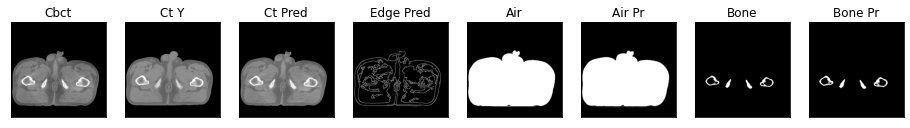

ssim score = 0.8711249828338623
psnr score = 25.239208221435547
snr score = 15.998437881469727
mae error = 0.020374715328216553
air dice score = 0.9976077298288147
bone dice score = 0.8904694167874321
contour dice score = 0.5792180895805359


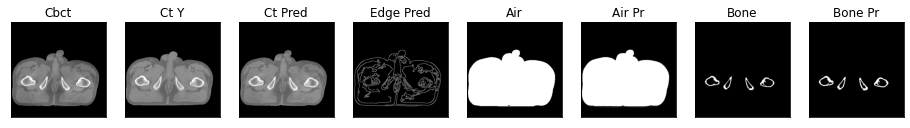

ssim score = 0.8654333353042603
psnr score = 25.019241333007812
snr score = 15.802642822265625
mae error = 0.020925849676132202
air dice score = 0.9978460632544607
bone dice score = 0.864177267134506
contour dice score = 0.6013478636741638


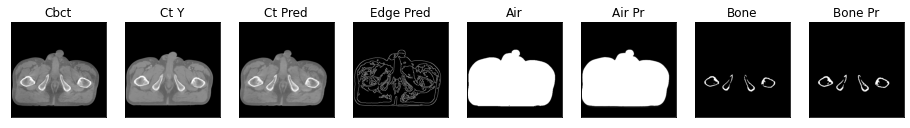

ssim score = 0.8651785254478455
psnr score = 24.871082305908203
snr score = 15.650089263916016
mae error = 0.021164173260331154
air dice score = 0.9977247751861213
bone dice score = 0.8782526115882573
contour dice score = 0.6081504821777344


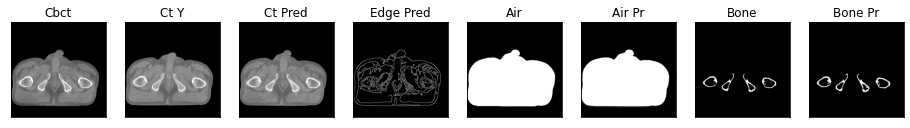

ssim score = 0.8654849529266357
psnr score = 24.41766357421875
snr score = 15.202923774719238
mae error = 0.02212444692850113
air dice score = 0.9973781294229584
bone dice score = 0.8759096846449728
contour dice score = 0.5726315975189209


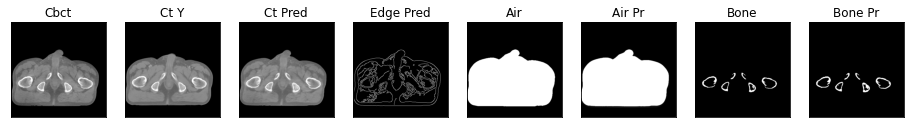

11it [00:28,  2.56s/it]

ssim score = 0.863261878490448
psnr score = 24.24481964111328
snr score = 15.008525848388672
mae error = 0.02207583375275135
air dice score = 0.9974067393811804
bone dice score = 0.8859436251654668
contour dice score = 0.6052631735801697


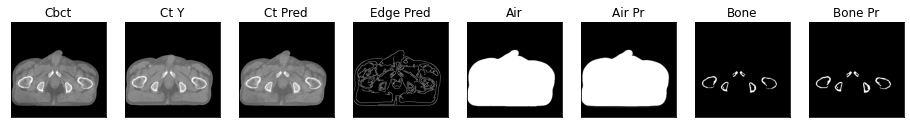

ssim score = 0.864402711391449
psnr score = 24.315832138061523
snr score = 15.09644603729248
mae error = 0.022137410938739777
air dice score = 0.9973993711912452
bone dice score = 0.8996428571446492
contour dice score = 0.6189718842506409


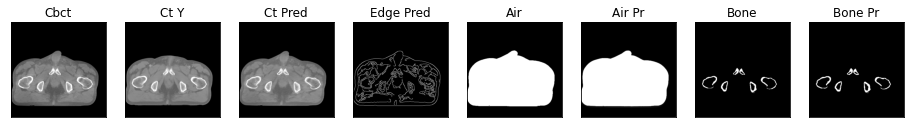

ssim score = 0.865007221698761
psnr score = 24.556049346923828
snr score = 15.40526008605957
mae error = 0.02233993075788021
air dice score = 0.9970847299088026
bone dice score = 0.9014360313332012
contour dice score = 0.6396588683128357


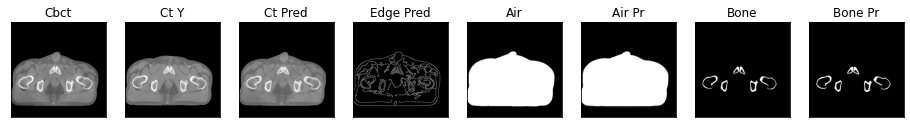

ssim score = 0.866176187992096
psnr score = 24.820634841918945
snr score = 15.751201629638672
mae error = 0.022891951724886894
air dice score = 0.9973003216138621
bone dice score = 0.8987341772167159
contour dice score = 0.6648764610290527


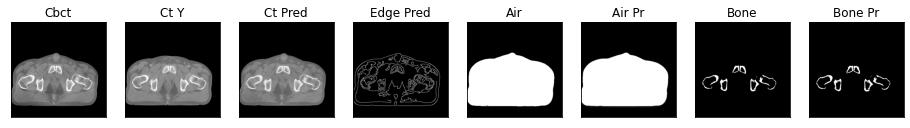

ssim score = 0.8666563034057617
psnr score = 25.069215774536133
snr score = 16.050487518310547
mae error = 0.023135056719183922
air dice score = 0.9974232878218946
bone dice score = 0.8835318036612906
contour dice score = 0.71750807762146


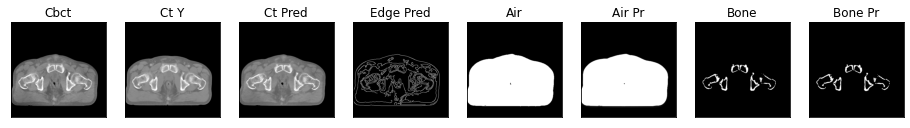

ssim score = 0.8684296607971191
psnr score = 25.2443904876709
snr score = 16.341930389404297
mae error = 0.023897714912891388
air dice score = 0.9975738861932087
bone dice score = 0.871787786683175
contour dice score = 0.7111350297927856


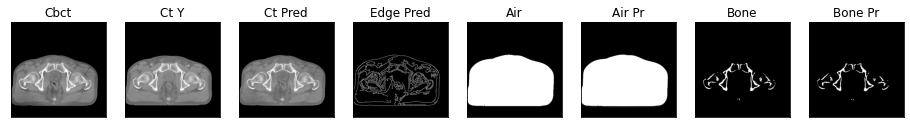

ssim score = 0.8683184385299683
psnr score = 24.995134353637695
snr score = 16.0544376373291
mae error = 0.023629678413271904
air dice score = 0.9978539243092583
bone dice score = 0.8671635247717789
contour dice score = 0.7556512355804443


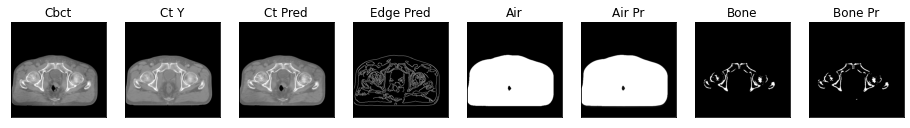

ssim score = 0.8615431189537048
psnr score = 24.25265884399414
snr score = 15.216289520263672
mae error = 0.02417047508060932
air dice score = 0.9976051345914378
bone dice score = 0.8784895482147203
contour dice score = 0.6537216901779175


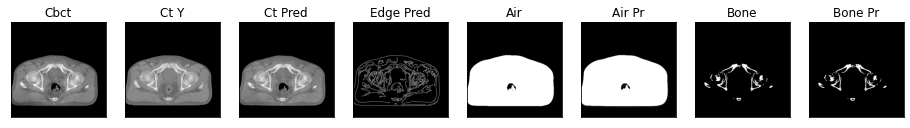

12it [00:31,  2.66s/it]

ssim score = 0.8663349747657776
psnr score = 24.14816665649414
snr score = 14.952038764953613
mae error = 0.022791663184762
air dice score = 0.9973386078748283
bone dice score = 0.8737190603835138
contour dice score = 0.6172972917556763


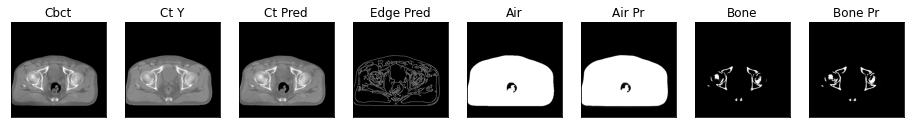

ssim score = 0.8650806546211243
psnr score = 23.888919830322266
snr score = 14.576369285583496
mae error = 0.022517481818795204
air dice score = 0.9971872662829665
bone dice score = 0.8748594377530143
contour dice score = 0.5616512894630432


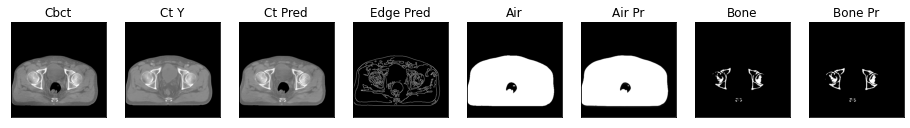

ssim score = 0.859226644039154
psnr score = 23.8080997467041
snr score = 14.450455665588379
mae error = 0.022780153900384903
air dice score = 0.9975538920931014
bone dice score = 0.8971679539618784
contour dice score = 0.5501089096069336


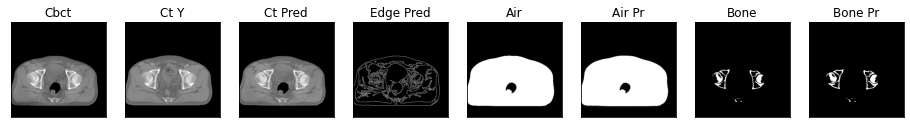

ssim score = 0.8524633049964905
psnr score = 23.303821563720703
snr score = 13.952848434448242
mae error = 0.02439245395362377
air dice score = 0.9976723219408264
bone dice score = 0.9125581395362394
contour dice score = 0.5264882445335388


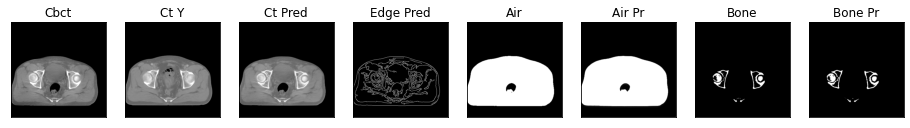

ssim score = 0.8561999797821045
psnr score = 23.06562042236328
snr score = 13.7447509765625
mae error = 0.025264745578169823
air dice score = 0.997742478348317
bone dice score = 0.9281934996231566
contour dice score = 0.5087527632713318


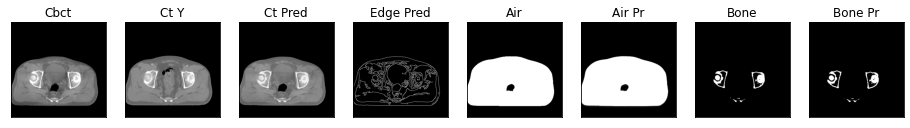

ssim score = 0.86296147108078
psnr score = 23.728649139404297
snr score = 14.365195274353027
mae error = 0.023367414250969887
air dice score = 0.9977125335126157
bone dice score = 0.917895442360625
contour dice score = 0.4906900227069855


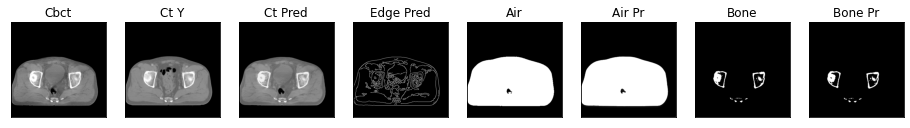

ssim score = 0.8642480969429016
psnr score = 24.048948287963867
snr score = 14.59528923034668
mae error = 0.021978752687573433
air dice score = 0.9979003186575232
bone dice score = 0.9049723756923578
contour dice score = 0.5005476474761963


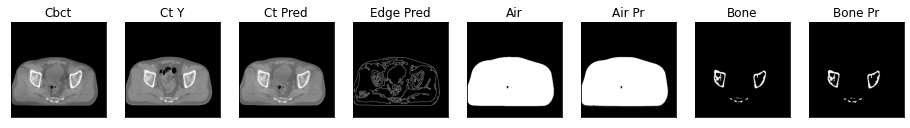

ssim score = 0.8649504780769348
psnr score = 23.68790054321289
snr score = 14.168519020080566
mae error = 0.02232171967625618
air dice score = 0.9975958138877123
bone dice score = 0.9110047846906985
contour dice score = 0.5244103074073792


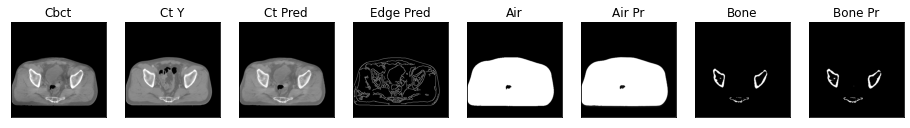

13it [00:34,  2.59s/it]

ssim score = 0.8627831935882568
psnr score = 23.711214065551758
snr score = 14.191527366638184
mae error = 0.02248459681868553
air dice score = 0.9973840865263709
bone dice score = 0.9137783848401267
contour dice score = 0.5099118947982788


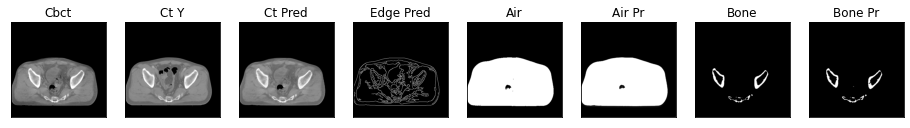

ssim score = 0.8582018613815308
psnr score = 23.553802490234375
snr score = 14.110282897949219
mae error = 0.024076633155345917
air dice score = 0.9971980733579972
bone dice score = 0.9011594202912876
contour dice score = 0.5723757147789001


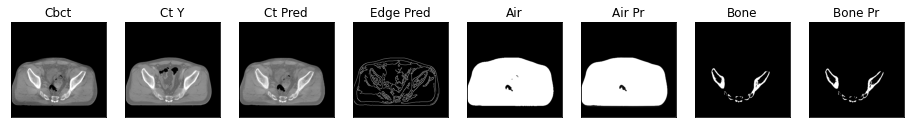

ssim score = 0.8624842762947083
psnr score = 23.768836975097656
snr score = 14.360899925231934
mae error = 0.023650145158171654
air dice score = 0.997196062555932
bone dice score = 0.8945274996585582
contour dice score = 0.5613259673118591


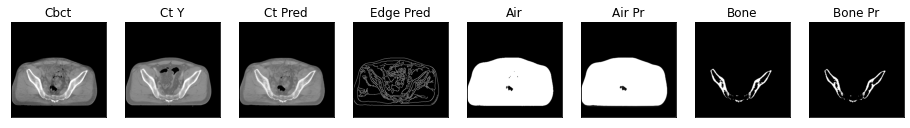

ssim score = 0.8630650639533997
psnr score = 24.364334106445312
snr score = 14.894697189331055
mae error = 0.022176263853907585
air dice score = 0.9976342316395823
bone dice score = 0.876608187136307
contour dice score = 0.5249722599983215


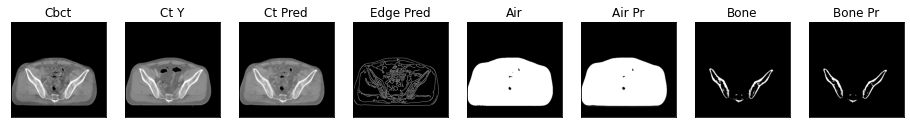

ssim score = 0.8564668297767639
psnr score = 24.102996826171875
snr score = 14.572100639343262
mae error = 0.02261548675596714
air dice score = 0.9975630833045303
bone dice score = 0.8771610555068674
contour dice score = 0.4377104341983795


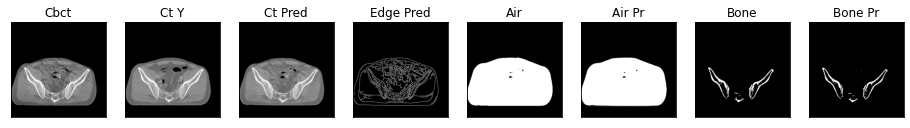

ssim score = 0.7843045592308044
psnr score = 22.156476974487305
snr score = 13.85378360748291
mae error = 0.03330160304903984
air dice score = 0.9980421499677646
bone dice score = 0.9402023919061575
contour dice score = 0.5192052721977234


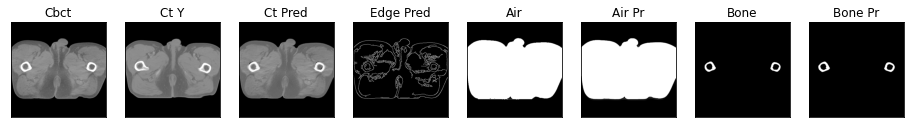

ssim score = 0.7776163816452026
psnr score = 21.809118270874023
snr score = 13.610713958740234
mae error = 0.03530898690223694
air dice score = 0.998076459273291
bone dice score = 0.9321517585175255
contour dice score = 0.524721622467041


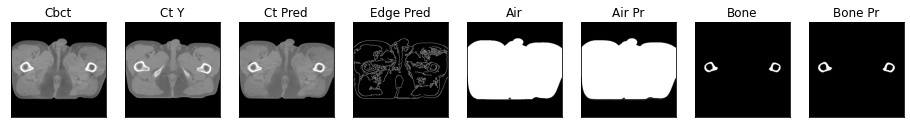

ssim score = 0.7752541899681091
psnr score = 21.488351821899414
snr score = 13.417906761169434
mae error = 0.03806758671998978
air dice score = 0.9979302621472517
bone dice score = 0.912955007915149
contour dice score = 0.5253249406814575


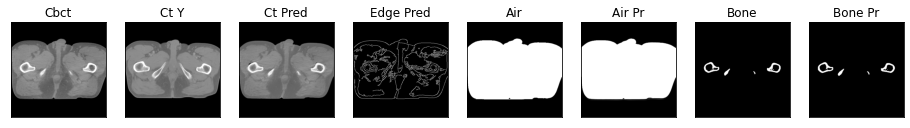

14it [00:36,  2.55s/it]

ssim score = 0.771355390548706
psnr score = 21.119285583496094
snr score = 13.081130027770996
mae error = 0.04068521410226822
air dice score = 0.9980348578781155
bone dice score = 0.905069751617811
contour dice score = 0.4768331050872803


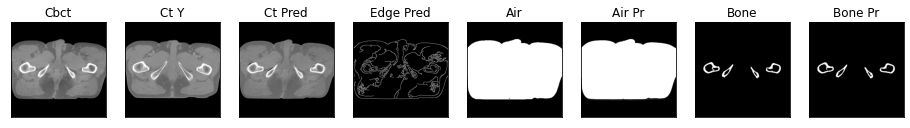

ssim score = 0.7616843581199646
psnr score = 20.93228530883789
snr score = 12.924365997314453
mae error = 0.04192744567990303
air dice score = 0.998039901995101
bone dice score = 0.8957276149959776
contour dice score = 0.4871215522289276


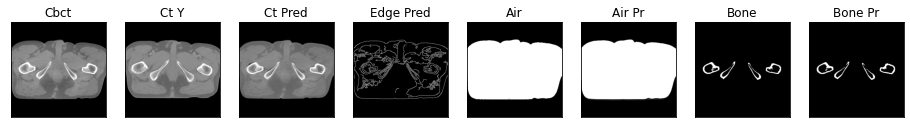

ssim score = 0.7566196322441101
psnr score = 20.7675724029541
snr score = 12.79407024383545
mae error = 0.04327293857932091
air dice score = 0.9978827607868697
bone dice score = 0.8948930188990334
contour dice score = 0.5090416073799133


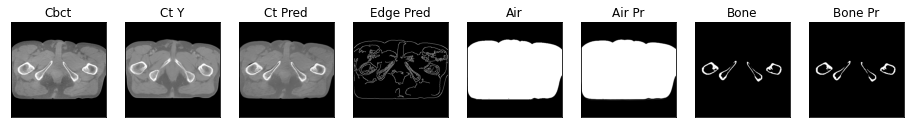

ssim score = 0.7497629523277283
psnr score = 20.461788177490234
snr score = 12.508594512939453
mae error = 0.04484531283378601
air dice score = 0.9977925456410032
bone dice score = 0.884311512416982
contour dice score = 0.5133062601089478


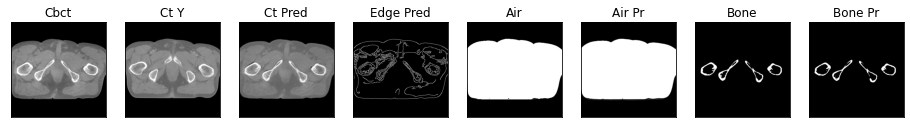

ssim score = 0.7499507069587708
psnr score = 20.39763641357422
snr score = 12.483516693115234
mae error = 0.04499341920018196
air dice score = 0.997559339286542
bone dice score = 0.8853422931557421
contour dice score = 0.5408071875572205


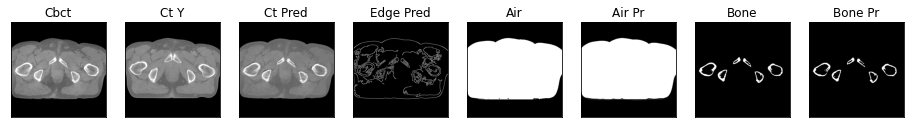

ssim score = 0.7494416832923889
psnr score = 20.458669662475586
snr score = 12.593229293823242
mae error = 0.04553241282701492
air dice score = 0.996981332839862
bone dice score = 0.8909952606649831
contour dice score = 0.5221546292304993


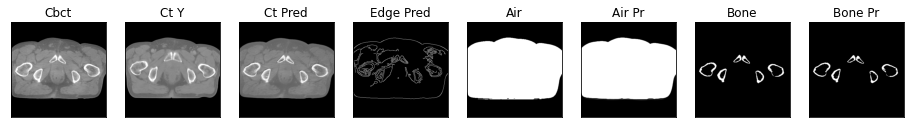

ssim score = 0.7426493763923645
psnr score = 20.215635299682617
snr score = 12.372806549072266
mae error = 0.04755297675728798
air dice score = 0.9971213540040942
bone dice score = 0.8928292046950087
contour dice score = 0.5091372728347778


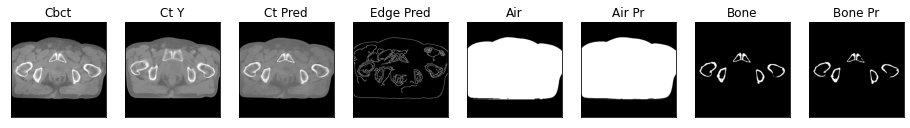

ssim score = 0.7317673563957214
psnr score = 20.172439575195312
snr score = 12.372389793395996
mae error = 0.04909152537584305
air dice score = 0.9976061513258474
bone dice score = 0.8852056476379963
contour dice score = 0.5042517185211182


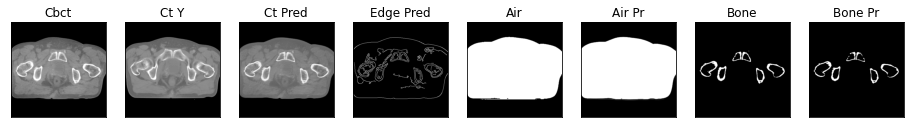

15it [00:39,  2.67s/it]

ssim score = 0.733397364616394
psnr score = 20.238895416259766
snr score = 12.497182846069336
mae error = 0.04901512712240219
air dice score = 0.9978040928949197
bone dice score = 0.8701923076937935
contour dice score = 0.502266526222229


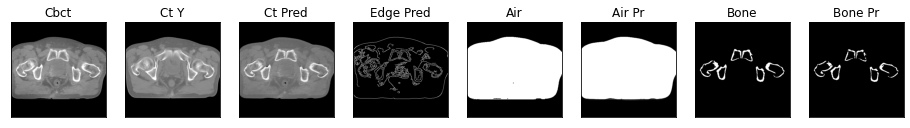

ssim score = 0.7309967279434204
psnr score = 20.28005599975586
snr score = 12.462970733642578
mae error = 0.04895814135670662
air dice score = 0.9982540776476003
bone dice score = 0.8259926231305489
contour dice score = 0.49384966492652893


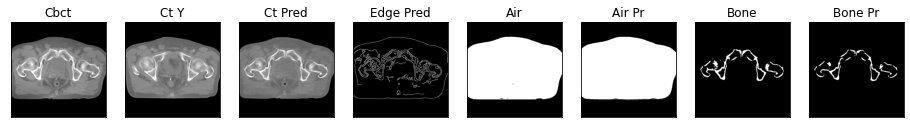

ssim score = 0.731768786907196
psnr score = 20.362716674804688
snr score = 12.438413619995117
mae error = 0.0480521060526371
air dice score = 0.9983232267548705
bone dice score = 0.8108166343480842
contour dice score = 0.4618198573589325


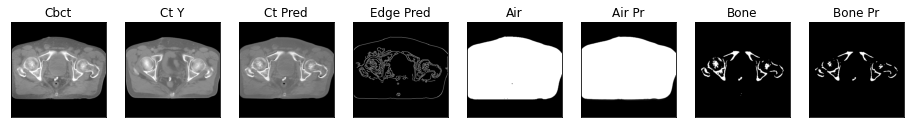

ssim score = 0.741736650466919
psnr score = 20.709068298339844
snr score = 12.661681175231934
mae error = 0.04557868465781212
air dice score = 0.9986089715586424
bone dice score = 0.7804290718062562
contour dice score = 0.45892611145973206


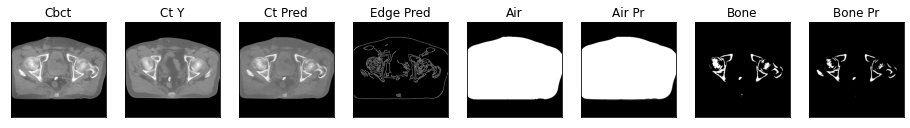

ssim score = 0.7495163083076477
psnr score = 20.91761016845703
snr score = 12.757791519165039
mae error = 0.043302614241838455
air dice score = 0.9988878196077986
bone dice score = 0.839647577094277
contour dice score = 0.4578535258769989


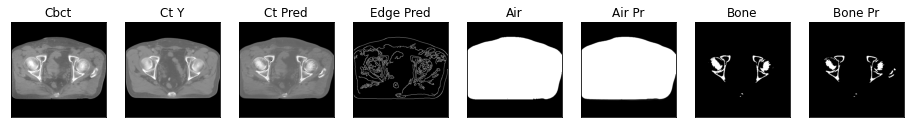

ssim score = 0.7481600046157837
psnr score = 21.152957916259766
snr score = 12.94249439239502
mae error = 0.04086296632885933
air dice score = 0.9987982158127072
bone dice score = 0.8801384681968829
contour dice score = 0.4574861228466034


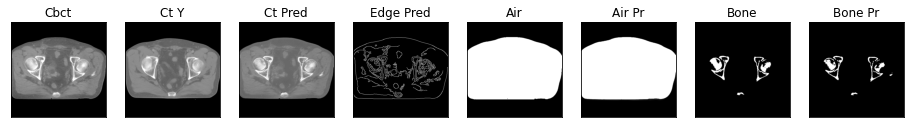

ssim score = 0.7474321722984314
psnr score = 20.934226989746094
snr score = 12.7559175491333
mae error = 0.04239795729517937
air dice score = 0.9989274305293862
bone dice score = 0.8988101983014298
contour dice score = 0.4588945806026459


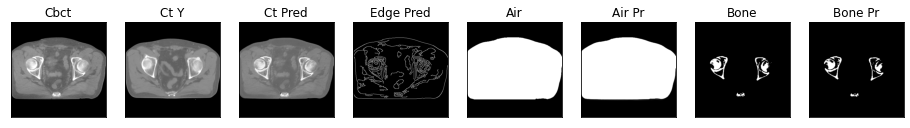

ssim score = 0.745486855506897
psnr score = 20.74348258972168
snr score = 12.578649520874023
mae error = 0.04354538396000862
air dice score = 0.9988651376093403
bone dice score = 0.8883715230990274
contour dice score = 0.4364486038684845


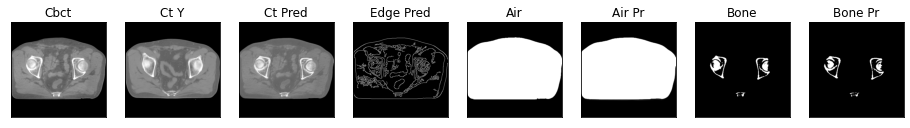

16it [00:42,  2.61s/it]

ssim score = 0.746046781539917
psnr score = 20.478900909423828
snr score = 12.172575950622559
mae error = 0.04464922100305557
air dice score = 0.9988008680545407
bone dice score = 0.8993008708463228
contour dice score = 0.40283018350601196


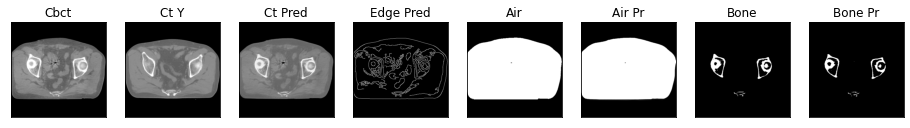

ssim score = 0.7532752752304077
psnr score = 20.545146942138672
snr score = 12.179513931274414
mae error = 0.043321024626493454
air dice score = 0.9989947976368933
bone dice score = 0.9104102707241082
contour dice score = 0.4380321800708771


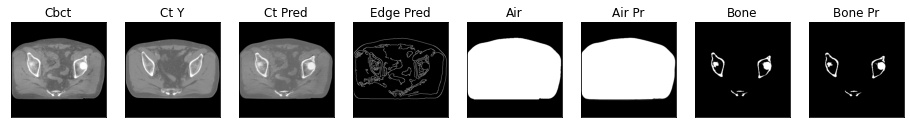

ssim score = 0.7460434436798096
psnr score = 20.821109771728516
snr score = 12.481121063232422
mae error = 0.0411747582256794
air dice score = 0.9989781754821186
bone dice score = 0.8870644043078441
contour dice score = 0.45243728160858154


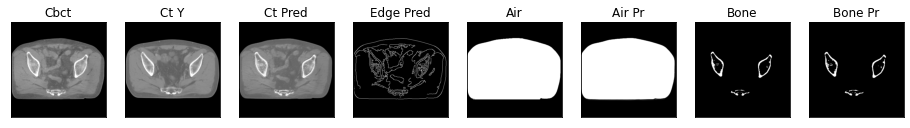

ssim score = 0.7406268119812012
psnr score = 20.627056121826172
snr score = 12.359882354736328
mae error = 0.042021553963422775
air dice score = 0.9988599657989746
bone dice score = 0.8877374784129924
contour dice score = 0.4765513837337494


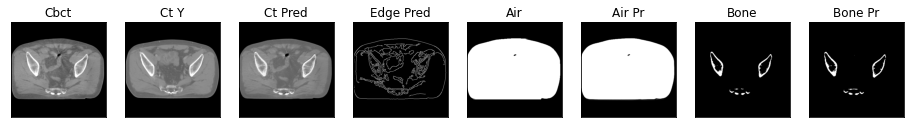

ssim score = 0.7347322702407837
psnr score = 20.221893310546875
snr score = 12.083950996398926
mae error = 0.044713981449604034
air dice score = 0.9987273172684532
bone dice score = 0.8950294310023703
contour dice score = 0.48331743478775024


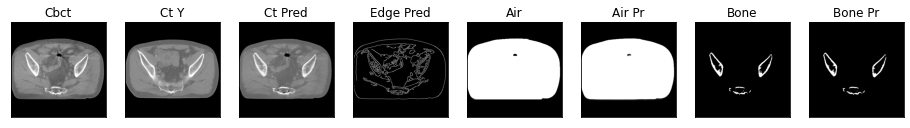

ssim score = 0.7304602861404419
psnr score = 20.08011817932129
snr score = 11.97613525390625
mae error = 0.04597485810518265
air dice score = 0.9985516565803478
bone dice score = 0.8867924528319112
contour dice score = 0.5076775550842285


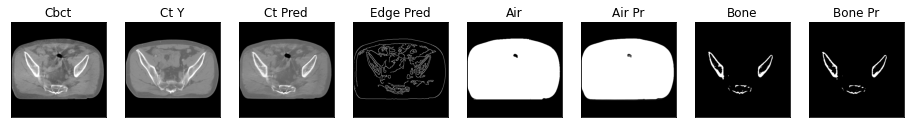

ssim score = 0.7221553921699524
psnr score = 20.12991714477539
snr score = 11.996145248413086
mae error = 0.0470549538731575
air dice score = 0.9985779191824249
bone dice score = 0.8761904761920484
contour dice score = 0.45620790123939514


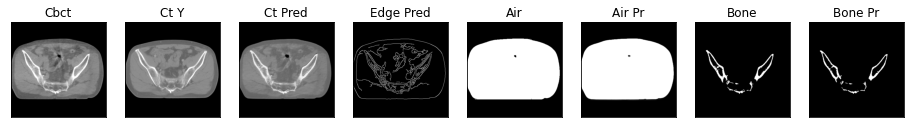

ssim score = 0.7205314636230469
psnr score = 20.41787338256836
snr score = 12.220726013183594
mae error = 0.04512641578912735
air dice score = 0.998404274609834
bone dice score = 0.853813846364262
contour dice score = 0.5507246255874634


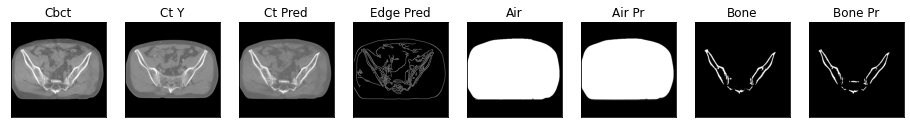

17it [00:44,  2.59s/it]

ssim score = 0.8377127051353455
psnr score = 22.902877807617188
snr score = 14.380268096923828
mae error = 0.0314348079264164
air dice score = 0.9969320844822638
bone dice score = 0.8899297423901155
contour dice score = 0.678051233291626


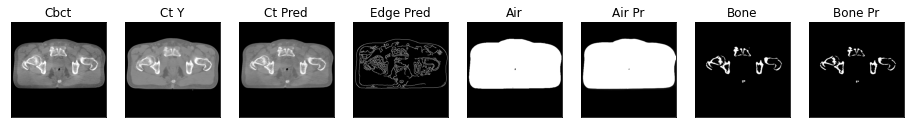

ssim score = 0.8418078422546387
psnr score = 22.933385848999023
snr score = 14.450787544250488
mae error = 0.031241731718182564
air dice score = 0.9973104536664538
bone dice score = 0.8780989081582775
contour dice score = 0.6955645084381104


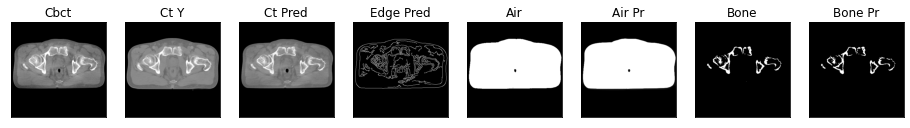

ssim score = 0.8393415212631226
psnr score = 23.005168914794922
snr score = 14.530359268188477
mae error = 0.03152867406606674
air dice score = 0.9973898470984314
bone dice score = 0.8730856305783316
contour dice score = 0.7368420958518982


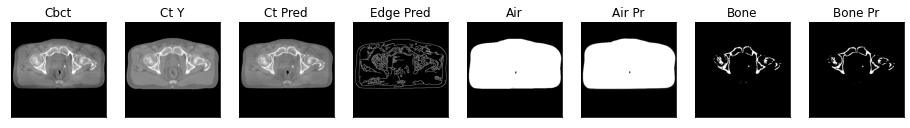

ssim score = 0.8437474966049194
psnr score = 22.98370361328125
snr score = 14.45047378540039
mae error = 0.030663635581731796
air dice score = 0.9973586112991932
bone dice score = 0.884128773645445
contour dice score = 0.7224758863449097


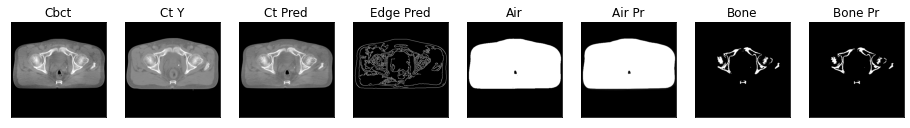

ssim score = 0.8490951657295227
psnr score = 23.215150833129883
snr score = 14.526298522949219
mae error = 0.02805199660360813
air dice score = 0.9975888864835831
bone dice score = 0.8918643574459051
contour dice score = 0.7250509262084961


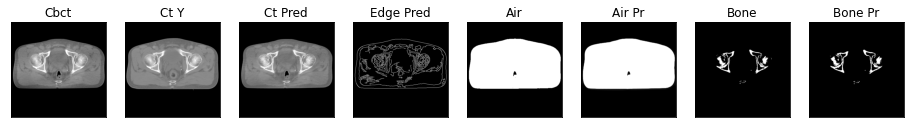

ssim score = 0.8521628975868225
psnr score = 23.332733154296875
snr score = 14.623077392578125
mae error = 0.027511801570653915
air dice score = 0.997522139793239
bone dice score = 0.8998620689668985
contour dice score = 0.7027578949928284


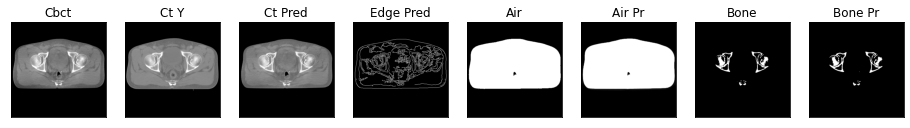

ssim score = 0.8455426096916199
psnr score = 23.25667381286621
snr score = 14.53138542175293
mae error = 0.027795417234301567
air dice score = 0.9975516702715712
bone dice score = 0.9115068493162807
contour dice score = 0.6793227195739746


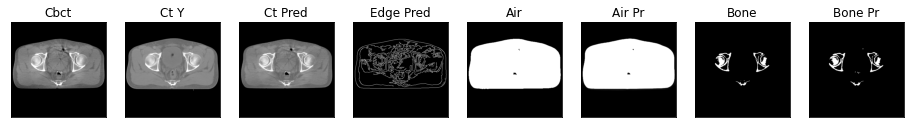

ssim score = 0.8368434906005859
psnr score = 22.644210815429688
snr score = 13.928285598754883
mae error = 0.029638363048434258
air dice score = 0.9975249766080125
bone dice score = 0.9057023643963046
contour dice score = 0.6999485492706299


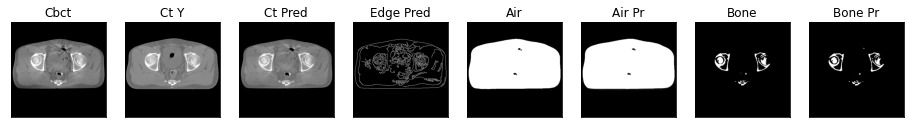

18it [00:47,  2.70s/it]

ssim score = 0.8311894536018372
psnr score = 22.63345718383789
snr score = 13.97331428527832
mae error = 0.03067312389612198
air dice score = 0.9977106676841494
bone dice score = 0.910121681417172
contour dice score = 0.6129198670387268


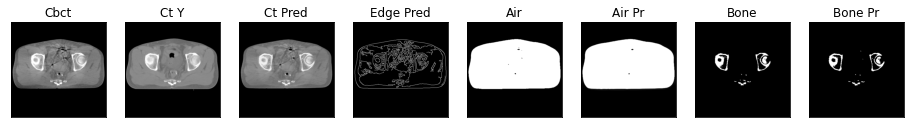

ssim score = 0.831379771232605
psnr score = 22.192066192626953
snr score = 13.509994506835938
mae error = 0.03205611929297447
air dice score = 0.9977070489264147
bone dice score = 0.9015691868772957
contour dice score = 0.5853658318519592


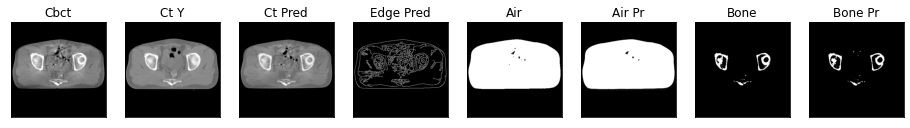

ssim score = 0.8297353982925415
psnr score = 21.79218101501465
snr score = 13.03933334350586
mae error = 0.032107312232255936
air dice score = 0.9978435302096288
bone dice score = 0.893986360819994
contour dice score = 0.5912408828735352


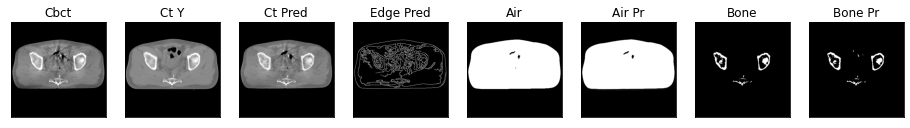

ssim score = 0.8306452035903931
psnr score = 22.05536651611328
snr score = 13.258626937866211
mae error = 0.031064841896295547
air dice score = 0.9979181759255745
bone dice score = 0.8962033566906273
contour dice score = 0.6052355766296387


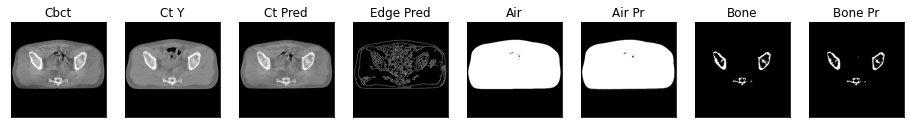

ssim score = 0.8319523334503174
psnr score = 22.312946319580078
snr score = 13.515110969543457
mae error = 0.030144840478897095
air dice score = 0.9979483096521329
bone dice score = 0.9039910242041355
contour dice score = 0.62572181224823


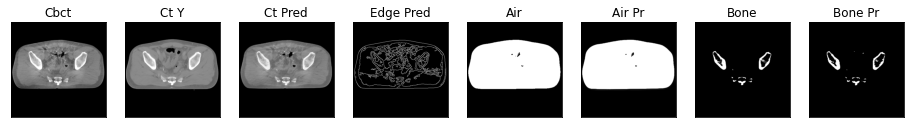

ssim score = 0.8267773389816284
psnr score = 22.20963478088379
snr score = 13.42515754699707
mae error = 0.030909938737750053
air dice score = 0.9977392614920891
bone dice score = 0.9078624078638228
contour dice score = 0.5845181941986084


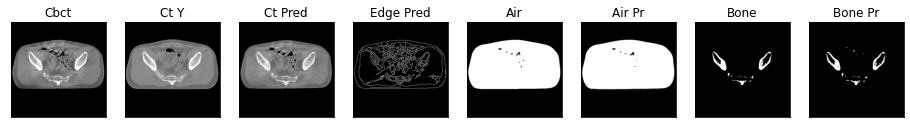

ssim score = 0.8254784345626831
psnr score = 22.083303451538086
snr score = 13.354028701782227
mae error = 0.03220891207456589
air dice score = 0.9976210705182686
bone dice score = 0.8977483443722153
contour dice score = 0.6067653298377991


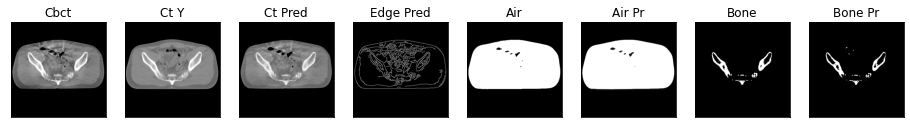

ssim score = 0.8254319429397583
psnr score = 21.646610260009766
snr score = 12.936704635620117
mae error = 0.03353456035256386
air dice score = 0.9974624787250522
bone dice score = 0.8780957622471368
contour dice score = 0.6416093111038208


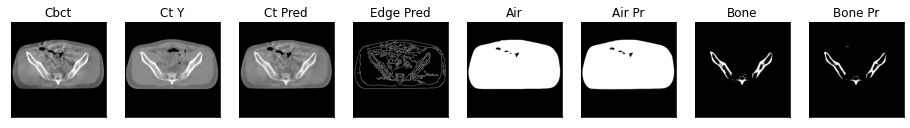

19it [00:50,  2.62s/it]

ssim score = 0.8314382433891296
psnr score = 21.924345016479492
snr score = 13.15970230102539
mae error = 0.03164305537939072
air dice score = 0.9976202249969113
bone dice score = 0.8756159474410091
contour dice score = 0.5620360374450684


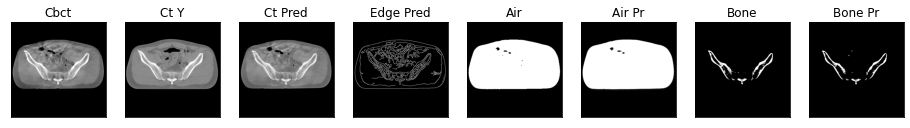

ssim score = 0.8347050547599792
psnr score = 22.199504852294922
snr score = 13.398509979248047
mae error = 0.030373359099030495
air dice score = 0.9974750399592319
bone dice score = 0.8652019002395308
contour dice score = 0.5782747864723206


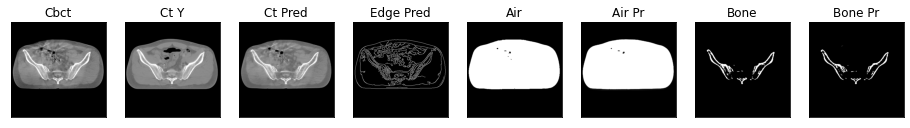

ssim score = 0.8382115960121155
psnr score = 22.39337921142578
snr score = 13.592453002929688
mae error = 0.02942541614174843
air dice score = 0.997605178993559
bone dice score = 0.8675712347372107
contour dice score = 0.5521669387817383


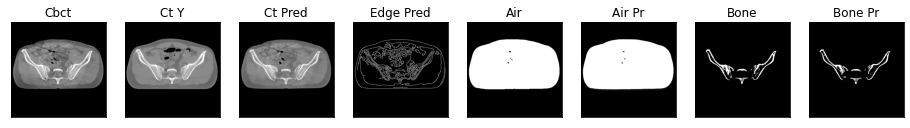

ssim score = 0.8368395566940308
psnr score = 22.62282943725586
snr score = 13.820484161376953
mae error = 0.029171761125326157
air dice score = 0.9975550122249408
bone dice score = 0.8708417508434904
contour dice score = 0.5723507404327393


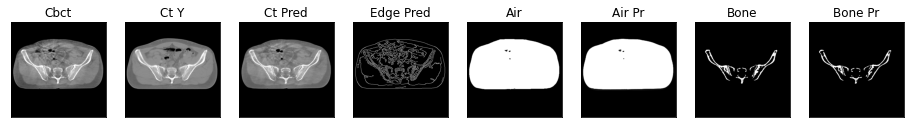

ssim score = 0.8262708783149719
psnr score = 22.035938262939453
snr score = 13.238629341125488
mae error = 0.030813144519925117
air dice score = 0.997462066824481
bone dice score = 0.862586137010369
contour dice score = 0.5516495108604431


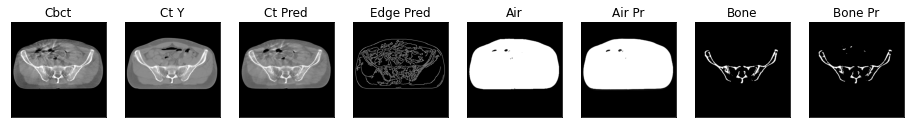

ssim score = 0.8179250955581665
psnr score = 21.470802307128906
snr score = 12.656221389770508
mae error = 0.032438114285469055
air dice score = 0.9968797778401847
bone dice score = 0.8530662642357928
contour dice score = 0.5370370149612427


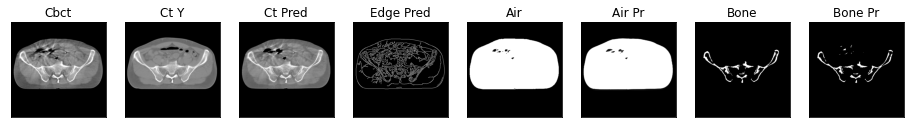

ssim score = 0.814487874507904
psnr score = 21.208908081054688
snr score = 12.375706672668457
mae error = 0.03339933604001999
air dice score = 0.9974394512438649
bone dice score = 0.8422568399025755
contour dice score = 0.5479452013969421


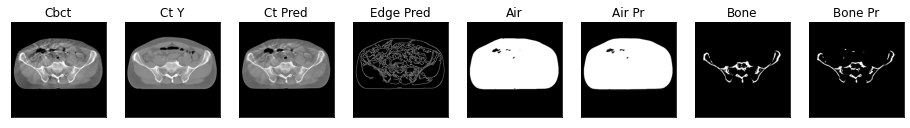

ssim score = 0.8062140345573425
psnr score = 20.87569808959961
snr score = 11.996556282043457
mae error = 0.03431534022092819
air dice score = 0.997335387469249
bone dice score = 0.8398378104429823
contour dice score = 0.5526751279830933


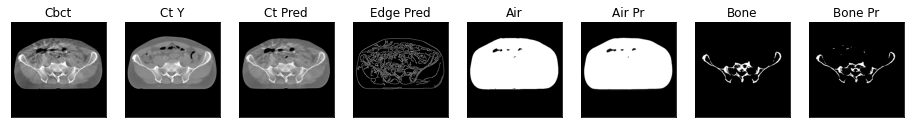

20it [00:52,  2.56s/it]

ssim score = 0.7992238998413086
psnr score = 20.835763931274414
snr score = 11.902824401855469
mae error = 0.03470170125365257
air dice score = 0.9968572827340085
bone dice score = 0.8460220318256301
contour dice score = 0.4814198613166809


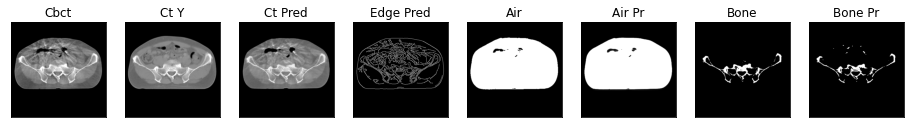

ssim score = 0.797019362449646
psnr score = 20.54189682006836
snr score = 11.639421463012695
mae error = 0.03612150996923447
air dice score = 0.9965171721659408
bone dice score = 0.864105642258534
contour dice score = 0.4891364872455597


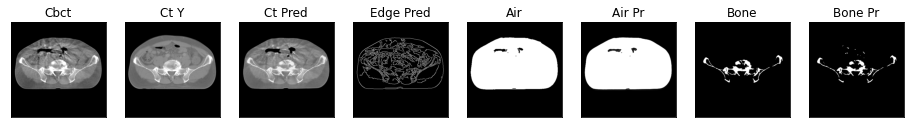

ssim score = 0.7888872623443604
psnr score = 20.360544204711914
snr score = 11.402841567993164
mae error = 0.035982172936201096
air dice score = 0.9967879915406536
bone dice score = 0.8755417956671759
contour dice score = 0.48164626955986023


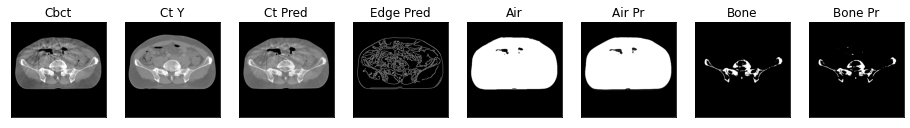

ssim score = 0.7941713929176331
psnr score = 21.07196617126465
snr score = 11.966732025146484
mae error = 0.03269089758396149
air dice score = 0.9971275571504753
bone dice score = 0.8837508028274406
contour dice score = 0.4093959629535675


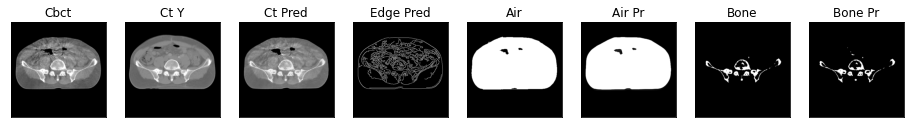

ssim score = 0.8571228384971619
psnr score = 25.183839797973633
snr score = 15.564752578735352
mae error = 0.021445224061608315
air dice score = 0.9950427325282101
bone dice score = 0.9066257354846092
contour dice score = 0.6301502585411072


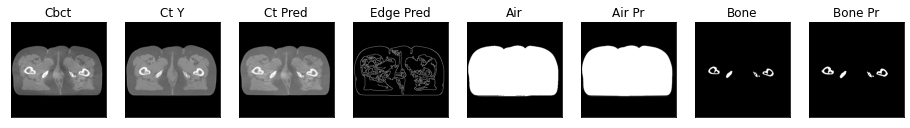

ssim score = 0.8591035008430481
psnr score = 25.406978607177734
snr score = 15.908900260925293
mae error = 0.020771915093064308
air dice score = 0.9956900330187333
bone dice score = 0.9061063690105908
contour dice score = 0.6452569365501404


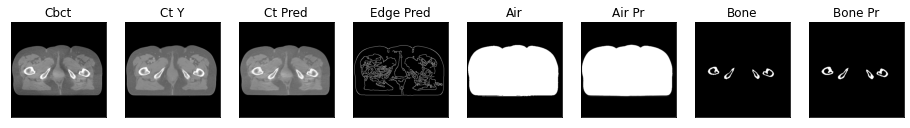

ssim score = 0.8558854460716248
psnr score = 25.3593807220459
snr score = 15.944219589233398
mae error = 0.02077482081949711
air dice score = 0.9957835303680188
bone dice score = 0.8994915917109993
contour dice score = 0.6273170709609985


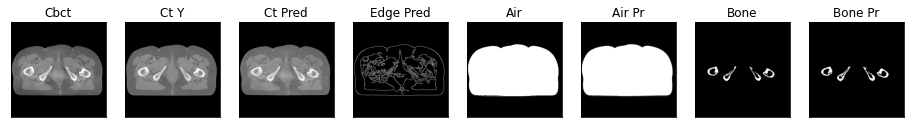

ssim score = 0.8542975187301636
psnr score = 25.326358795166016
snr score = 15.974647521972656
mae error = 0.020971648395061493
air dice score = 0.9958900646466136
bone dice score = 0.899205648721991
contour dice score = 0.6497560739517212


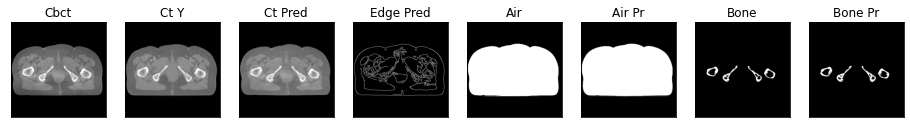

21it [00:55,  2.64s/it]

ssim score = 0.8547641634941101
psnr score = 25.25738525390625
snr score = 15.934133529663086
mae error = 0.021071244031190872
air dice score = 0.996164004980319
bone dice score = 0.9042080054754669
contour dice score = 0.6515970230102539


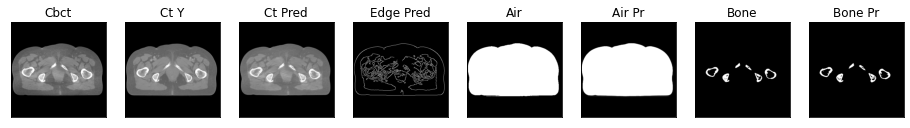

ssim score = 0.8572068810462952
psnr score = 25.218456268310547
snr score = 15.918157577514648
mae error = 0.020791560411453247
air dice score = 0.995793614333298
bone dice score = 0.9106984969069726
contour dice score = 0.6627737283706665


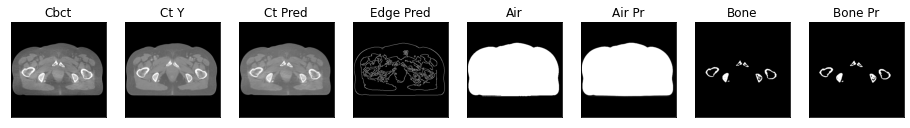

ssim score = 0.8532407879829407
psnr score = 25.112995147705078
snr score = 15.844024658203125
mae error = 0.020992746576666832
air dice score = 0.9958611998224213
bone dice score = 0.9089647997241379
contour dice score = 0.6396135091781616


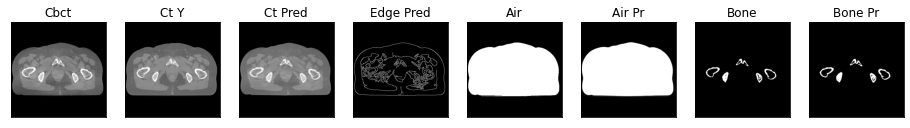

ssim score = 0.853003978729248
psnr score = 24.988014221191406
snr score = 15.767406463623047
mae error = 0.02148103155195713
air dice score = 0.9958455190955989
bone dice score = 0.9021683455710745
contour dice score = 0.6390977501869202


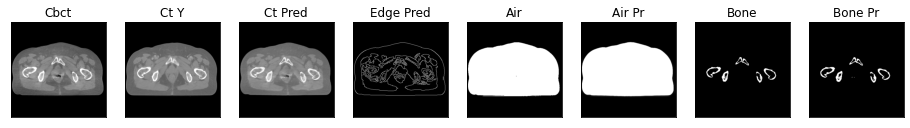

ssim score = 0.8532019257545471
psnr score = 24.594486236572266
snr score = 15.41662311553955
mae error = 0.021793032065033913
air dice score = 0.9957516199630979
bone dice score = 0.9047009913670498
contour dice score = 0.6503362059593201


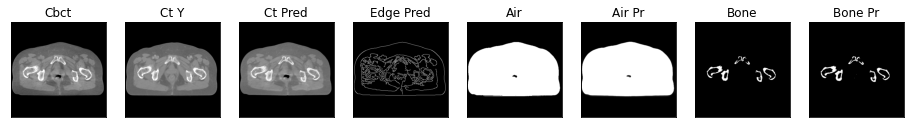

ssim score = 0.8505982160568237
psnr score = 24.431034088134766
snr score = 15.340871810913086
mae error = 0.022374039515852928
air dice score = 0.9957080931057699
bone dice score = 0.8965024982170378
contour dice score = 0.6227824687957764


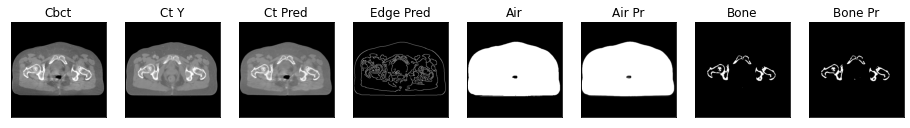

ssim score = 0.8544755578041077
psnr score = 25.323104858398438
snr score = 16.34621810913086
mae error = 0.02158692479133606
air dice score = 0.995506818100904
bone dice score = 0.8988626635697827
contour dice score = 0.5987085103988647


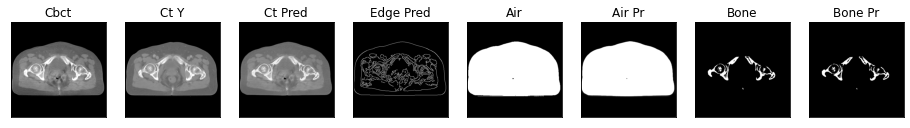

ssim score = 0.856488823890686
psnr score = 24.71360969543457
snr score = 15.608171463012695
mae error = 0.021361492574214935
air dice score = 0.9954206314107626
bone dice score = 0.8889966068849734
contour dice score = 0.6263279318809509


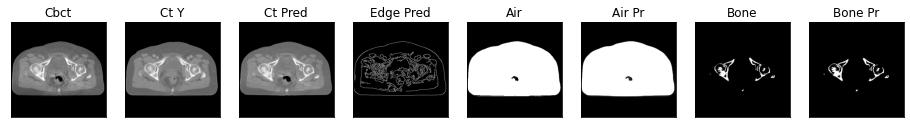

22it [00:57,  2.57s/it]

ssim score = 0.858805239200592
psnr score = 24.84402084350586
snr score = 15.629159927368164
mae error = 0.020753642544150352
air dice score = 0.9956008698442155
bone dice score = 0.8768630234230507
contour dice score = 0.5935604572296143


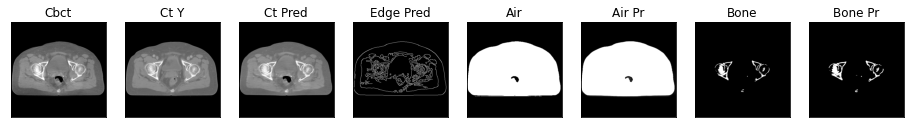

ssim score = 0.8602200150489807
psnr score = 24.868160247802734
snr score = 15.626172065734863
mae error = 0.02107413113117218
air dice score = 0.9953869227433982
bone dice score = 0.9062346588135127
contour dice score = 0.6349061131477356


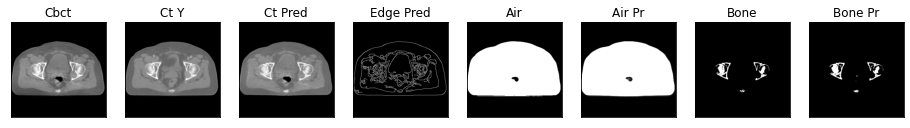

ssim score = 0.8628621101379395
psnr score = 25.501293182373047
snr score = 16.251300811767578
mae error = 0.020805835723876953
air dice score = 0.9957430613309306
bone dice score = 0.9169082125617245
contour dice score = 0.6551563143730164


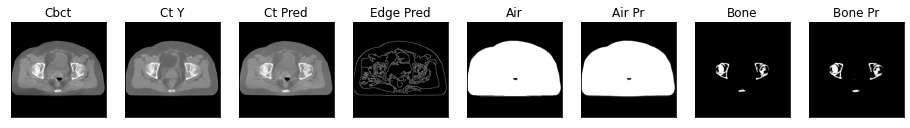

ssim score = 0.8620023131370544
psnr score = 26.150388717651367
snr score = 16.93462562561035
mae error = 0.019950170069932938
air dice score = 0.9962053711817884
bone dice score = 0.9242185033166369
contour dice score = 0.6258823275566101


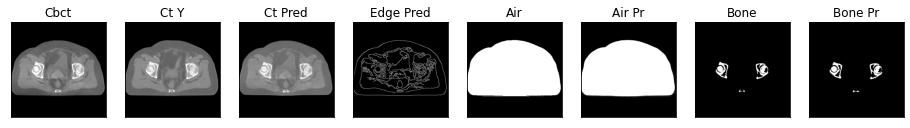

ssim score = 0.8594894409179688
psnr score = 25.63327980041504
snr score = 16.469009399414062
mae error = 0.02117394283413887
air dice score = 0.9965584235359447
bone dice score = 0.932783766646595
contour dice score = 0.6445406675338745


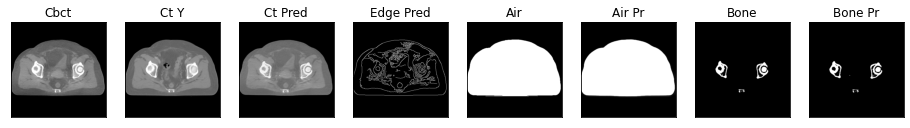

ssim score = 0.8467243313789368
psnr score = 24.778724670410156
snr score = 15.65201187133789
mae error = 0.02295384556055069
air dice score = 0.9964632703052346
bone dice score = 0.9247787610632271
contour dice score = 0.6508932709693909


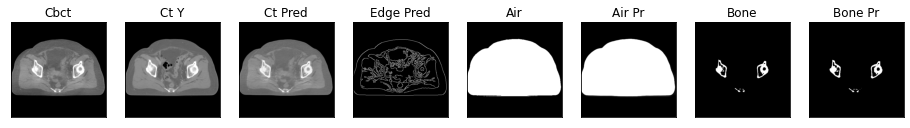

ssim score = 0.8261466026306152
psnr score = 23.163917541503906
snr score = 13.964766502380371
mae error = 0.02661842852830887
air dice score = 0.9964165045561609
bone dice score = 0.893005828478497
contour dice score = 0.6360527873039246


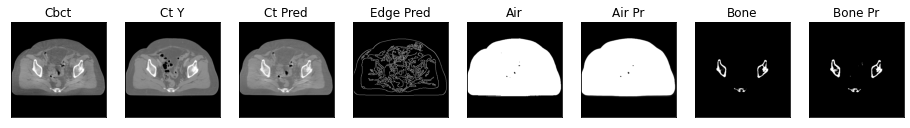

ssim score = 0.8146271705627441
psnr score = 22.674816131591797
snr score = 13.457672119140625
mae error = 0.028370367363095284
air dice score = 0.9966790043804566
bone dice score = 0.8988057825288329
contour dice score = 0.6426455974578857


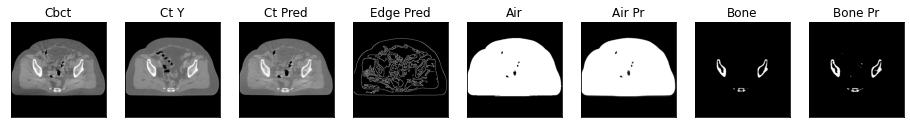

23it [01:00,  2.53s/it]

ssim score = 0.8110796809196472
psnr score = 23.267841339111328
snr score = 14.11561107635498
mae error = 0.02757318876683712
air dice score = 0.9969440321313213
bone dice score = 0.9011475739903131
contour dice score = 0.6264821887016296


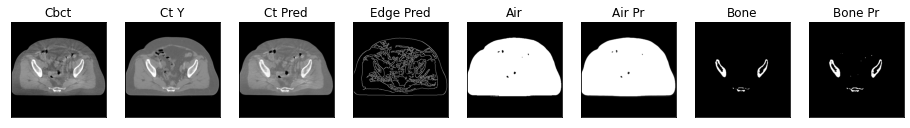

ssim score = 0.8139670491218567
psnr score = 23.44562339782715
snr score = 14.348487854003906
mae error = 0.027331126853823662
air dice score = 0.9972302488781195
bone dice score = 0.912666076175152
contour dice score = 0.6172224879264832


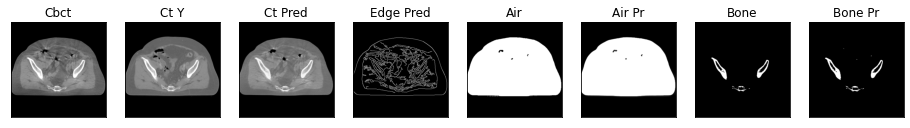

ssim score = 0.810667872428894
psnr score = 22.8225040435791
snr score = 13.78979778289795
mae error = 0.02902151085436344
air dice score = 0.9973880695459479
bone dice score = 0.9061004784703035
contour dice score = 0.5867322087287903


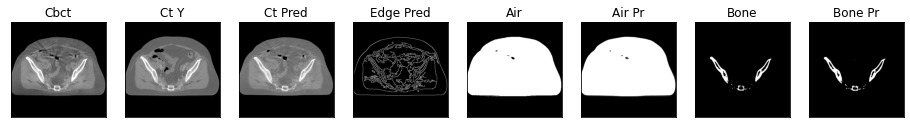

ssim score = 0.8085753321647644
psnr score = 22.731643676757812
snr score = 13.771797180175781
mae error = 0.029264045879244804
air dice score = 0.9975794211545522
bone dice score = 0.9000421762983264
contour dice score = 0.5517241358757019


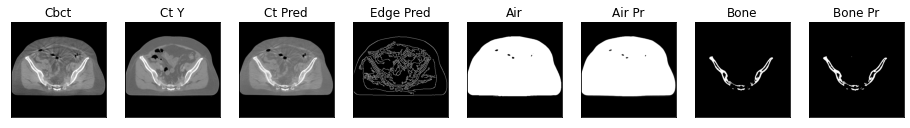

ssim score = 0.8098596930503845
psnr score = 22.68388557434082
snr score = 13.719749450683594
mae error = 0.029509613290429115
air dice score = 0.9974949379575324
bone dice score = 0.8941109041425117
contour dice score = 0.568359375


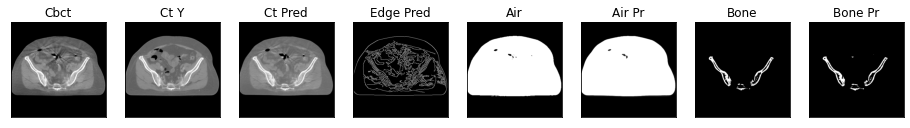

ssim score = 0.8097224235534668
psnr score = 22.737886428833008
snr score = 13.751574516296387
mae error = 0.029617011547088623
air dice score = 0.9979488300615365
bone dice score = 0.90153293744094
contour dice score = 0.5240174531936646


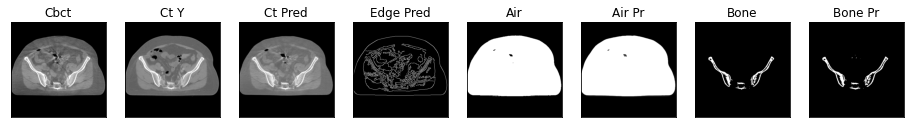

ssim score = 0.8165626525878906
psnr score = 23.486413955688477
snr score = 14.511736869812012
mae error = 0.028058724477887154
air dice score = 0.9978520666687926
bone dice score = 0.8951464553573631
contour dice score = 0.5612343549728394


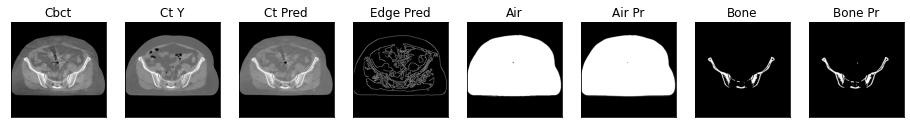

24it [01:02,  2.62s/it]


In [40]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [41]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [42]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [43]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:03,  6.00it/s]


(0.834637368718783,
 23.124075412750244,
 14.138645648956299,
 0.029035352791349094,
 0.9973054548421897,
 0.8848640769595065,
 0.5141309666696019,
 0.5)

In [44]:
# import torchvision.models as models
# models.vgg16(pretrained=True)